<a href="https://colab.research.google.com/github/Maymiyam/ml_customer_spending_prediction/blob/main/Customer_spending_prediction_ipynb%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ влияния поведения клиентов на их годовые траты в интернет-магазине

## Задача проекта

Цель данного проекта — разработать модель машинного обучения, которая может прогнозировать годовые траты клиентов интернет-магазина на основе их поведения и взаимодействия с компанией. Модель будет использоваться для выявления ключевых факторов, влияющих на уровень трат клиентов, что позволит компании оптимизировать маркетинговые стратегии и улучшить пользовательский опыт.

## Описание переменных

Данные содержат следующие переменные:

- **Avg. Session Length**: Среднее время консультации с стилистом клиента в оффлайн-формате. Отражает продолжительность взаимодействия клиента со стилистом в минутах.
- **Time on App**: Среднее время, проведенное клиентом в мобильном приложении компании. Показатель, измеряемый в минутах, который может указывать на вовлеченность клиента через мобильное приложение.
- **Time on Website**: Среднее время, проведенное клиентом на сайте компании. Подобно времени в приложении, измеряется в минутах и отражает вовлеченность клиента через веб-платформу.
- **Length of Membership**: Длительность членства клиента в программе лояльности компании, измеряемая в годах. Показатель, который может отражать уровень лояльности клиента к бренду.
- **Yearly Amount Spent** (целевая переменная): Общая сумма денег, потраченная клиентом на услуги компании за последний год. Измеряется в долларах и является ключевым показателем, который нужно предсказать.

## Цели анализа

1. **Исследовать взаимосвязь** между временем взаимодействия клиентов с компанией (время консультации, время на сайте и в приложении) и их годовыми тратами.
2. **Оценить влияние** длительности членства в программе лояльности на годовые траты клиентов.
3. **Разработать модель** машинного обучения для прогнозирования годовых трат клиентов на основе указанных выше факторов.
4. **Предоставить рекомендации** для улучшения маркетинговых стратегий и пользовательского опыта на основе результатов анализа.

In [69]:
# импорт библиотек
import pandas as pd
import numpy as np

# для визуализаций
from matplotlib import pyplot as plt
import seaborn as sns

# для обучения моделей
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
from sklearn import metrics

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


import warnings
warnings.filterwarnings("ignore")

In [70]:
# установка цветового стиля
plt.style.use('dark_background') # стиль matplotlib
sns.set(style='darkgrid') # сетка
sns.set_palette('coolwarm') # стиль seaborn flare cubehelix

# Анализ данных

### Функции для обработки данных

1. Функция для поиска пропусков
2. Функция для поиска дубликатов
3. Поиск числовых/категориальных столбцов
4. Визуализации (распределения, боксплот)
5. Найти выбросы по IQR
6. Построить Heatmap


In [71]:
# поиск пропусков
def check_missing_values(df):
    """
    Проверяет наличие пропущенных значений в DataFrame и печатает количество пропусков по каждому столбцу.
    """
    missing_values = df.isnull().sum()
    missing_values = missing_values[missing_values > 0]
    if len(missing_values) > 0:
        print("Пропущенные значения по столбцам:\n", missing_values)
    else:
        print("Пропущенные значения отсутствуют.")

# поиск дубликатов
def check_duplicates(df):
    """
    Проверяет DataFrame на наличие дубликатов и печатает их количество.
    """
    duplicates = df.duplicated().sum()
    if duplicates > 0:
        print(f"Найдено {duplicates} дубликатов.")
    else:
        print("Дубликаты отсутствуют.")

In [72]:
# EDA
# найти числовые столбцы
def find_numeric_cols(df):
  """
  Находит числовые признаки и возвращает их в виде списка.
  """
  return df.select_dtypes(include=['float', 'int']).columns.tolist()

# найти категориальные столбцы
def find_categorical_cols(df):
  """
  Находит категориальные признаки и возвращает их в виде списка.
  """
  return df.select_dtypes(include=['object']).columns.tolist()

In [73]:
# анализ числовых признаков

# распределения числовых признаков
def plot_numerical_distributions(df, cols):
    """
    Строит сетку гистограмм для числовых столбцов DataFrame, по два распределения в строке.

    Параметры:
    df (DataFrame): DataFrame для анализа.
    cols (list): Список столбцов для визуализации.
    """
    num_plots = len(cols)
    num_cols = 2
    num_rows = num_plots // num_cols + (num_plots % num_cols > 0)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10 * num_cols, 4 * num_rows))
    axes = axes.flatten()  # превращаем двумерный массив осей в одномерный для удобства итерации

    for i, col in enumerate(cols):
        sns.histplot(df[col], kde=True, bins=30, ax=axes[i])
        mean_val = df[col].mean()
        std_val = df[col].std()
        axes[i].axvline(mean_val, color='r', linestyle='--', label=f'Mean: {mean_val:.2f}')
        axes[i].axvline(mean_val - std_val, color='g', linestyle='--', label=f'Mean - Std: {mean_val - std_val:.2f}')
        axes[i].axvline(mean_val + std_val, color='b', linestyle='--', label=f'Mean + Std: {mean_val + std_val:.2f}')
        axes[i].legend()
        axes[i].set_title(f'Распределение для {col}')

    # убираем лишние графики, если число признаков нечетное
    for ax in axes[num_plots:]:
        ax.remove()

    plt.tight_layout()  # автоматически корректирует подложку под размер графика
    plt.show()

# боксплоты для числовых признаков
def plot_boxplots(df, cols):
    """
    Строит сетку боксплотов для числовых столбцов DataFrame.

    Параметры:
    df (DataFrame): DataFrame для анализа.
    cols (list): Список столбцов для визуализации.
    """
    # расчет количества строк
    num_plots = len(cols)
    num_cols = 2
    num_rows = num_plots // num_cols + num_plots % num_cols

    # создание сетки графиков
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10 * num_cols, 4 * num_rows))
    axes = axes.flatten()

    # строим боксплот для каждого числового признака из списка col
    for i, col in enumerate(cols):
        sns.boxplot(x=df[col], ax=axes[i])
        # расчет mean & std
        mean_val = df[col].mean()
        std_val = df[col].std()
        # добавляем линии
        axes[i].axvline(mean_val, color='r', linestyle='--', label=f'Mean: {mean_val:.2f}')
        axes[i].axvline(mean_val - std_val, color='g', linestyle='--', label=f'Mean - Std: {mean_val - std_val:.2f}')
        axes[i].axvline(mean_val + std_val, color='b', linestyle='--', label=f'Mean + Std: {mean_val + std_val:.2f}')
        # легенда и заголовок
        axes[i].legend()
        axes[i].set_title(f'Boxplot для {col}')

    # убираем лишние графики, если число признаков нечетное
    for ax in axes[num_plots:]:
        ax.remove()

    plt.tight_layout()  # автоматически корректирует подложку под размер графика
    plt.show()

# поиск выбросов по IQR, вывод строк и значений выбросов
def find_outliers(df, numeric_cols):
    """
    Проверяет наличие выбросов в числовых столбцах DataFrame с использованием IQR.

    Параметры:
    df (DataFrame): DataFrame для анализа.
    numeric_cols (list): Список числовых столбцов для проверки.

    Возвращает:
    dict: Словарь, содержащий столбцы и соответствующие выбросы.
    """
    outliers_dict = {}

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # определяем выбросы как значения за пределами межквартильного размаха
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

        # если в столбце есть выбросы, добавляем их в словарь
        if not outliers.empty:
            outliers_dict[col] = outliers
            print(f"Кол-во выбросов в колонке {col}: {len(outliers.index.tolist())}")

    return outliers_dict

In [74]:
# матрица корреляций по Пирсону
def plot_pirson_correlation_matrix(df):
    """
    Визуализирует матрицу корреляций Пирсона для всех числовых столбцов DataFrame.

    Параметры:
    df (DataFrame): DataFrame для анализа.
    """
    plt.figure(figsize=(12, 10))
    sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Матрица корреляций')
    plt.show()

# матрица корреляций по Спирмену
def plot_spearman_correlation_matrix(df):
    """
    Визуализирует матрицу корреляций Спирмена для всех числовых столбцов DataFrame.

    Параметры:
    df (DataFrame): DataFrame для анализа.
    """
    plt.figure(figsize=(12, 10))
    sns.heatmap(df.corr(method='spearman'), annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Матрица корреляций по Спирмену')
    plt.show()

# plot_pirson_correlation_matrix(df)
# plot_spearman_correlation_matrix(df)

In [75]:
df = pd.read_csv('https://raw.githubusercontent.com/obulygin/content/main/ecommers_customers/ecommerce.csv')
df.sample(10)

,Email,Address,Avatar,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
200,jessica04@christian-riley.com,"338 Graham Loaf Suite 236\nEast Toddton, FM 43...",LemonChiffon,34.878495,13.067896,36.678222,1.920715,504.870432
479,annstone@hotmail.com,"543 Reynolds Burg\nMelindaberg, KY 46631",LightPink,34.606242,11.761884,38.126520,1.820811,402.167122
291,samantha84@cortez.com,"960 Miller Union\nEast Virginiastad, MS 74191-...",Navy,33.539396,10.534553,37.034791,2.214798,378.473566
489,tracy79@wheeler.net,"513 Moore Crescent Apt. 416\nAmandaberg, GU 03...",Magenta,32.246350,11.305551,37.133127,1.707390,327.377953
68,ellen24@anthony.com,"PSC 3408, Box 3353\nAPO AE 05113-1257",LimeGreen,32.430758,11.306232,37.680403,2.779521,408.620188
346,justin26@gmail.com,"32303 Baldwin Causeway\nSouth Robertside, HI 5...",RosyBrown,32.765665,12.506548,35.823467,3.126509,488.387526
340,vancealicia@hotmail.com,"06307 Scott Spurs Suite 161\nJessicaburgh, NH ...",RoyalBlue,31.816428,14.288015,36.773861,2.964498,501.122492
389,nblack@smith-romero.biz,"00615 Tracy Islands\nNew Marcfort, MO 87297-7431",LightCyan,34.195508,12.664193,37.027150,4.330407,581.308933
398,rogerstiffany@wilson-horne.com,"30700 Justin Ports\nPort David, PA 52171-5921",DarkOliveGreen,34.140393,11.568527,38.918749,4.082855,537.825282
154,nathan86@hotmail.com,"748 Michael Plaza\nWest Billyside, UT 20799",MidnightBlue,36.139662,12.050267,36.959643,3.864861,595.803819


### Анализ и обработка числовых признаков

In [76]:
df.shape

(500, 8)

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Email                 500 non-null    object 
 1   Address               500 non-null    object 
 2   Avatar                500 non-null    object 
 3   Avg. Session Length   500 non-null    float64
 4   Time on App           500 non-null    float64
 5   Time on Website       500 non-null    float64
 6   Length of Membership  500 non-null    float64
 7   Yearly Amount Spent   500 non-null    float64
dtypes: float64(5), object(3)
memory usage: 31.4+ KB


Датасет содержит 500 строк и 8 признаков. Видим, что пропусков нет, проверим данные на дубликаты.

In [78]:
# проверка на дубликаты
check_duplicates(df)

Дубликаты отсутствуют.


Типы данных корректны, пропусков и дубликатов нет.

Теперь более подробно **изучим числовые данные.**

In [79]:
df.describe()

,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,33.053194,12.052488,37.060445,3.533462,499.314038
std,0.992563,0.994216,1.010489,0.999278,79.314782
min,29.532429,8.508152,33.913847,0.269901,256.670582
25%,32.341822,11.388153,36.349257,2.930450,445.038277
50%,33.082008,11.983231,37.069367,3.533975,498.887875
75%,33.711985,12.753850,37.716432,4.126502,549.313828
max,36.139662,15.126994,40.005182,6.922689,765.518462


- **Avg. Session Length**: Минимальное среднее время оффлайн-консультации со стилистом составляет около 30 минут, максимальное 36 при глобальном среднем значении 33 минуты и стандартном отклонении в 1 минуту, что может говорить о том, что время на офлайн консультацию достаточно стандартизировано (около 30 мин)
- **Time on App**: Среднее время, проведенное клиентом в мобильном приложении 12 минут, небольшое стандартное отклонение говорит о том, что большинство клиентов проводят в приложении от 11 до 13 минут.
- **Time on Website**: Среднее время, проведенное клиентом на сайте компании тоже достаточно однородно - в среднем 36-38 минут.
- **Length of Membership**: Минимальная длительность членства клиента в программе лояльности - 0.27 лет (чуть больше 3 месяцев), а самый лояльный клиент состоит в программе 7 лет.
- **Yearly Amount Spent** (целевая переменная):  В среднем клиенты тратили около $500 в год, минимальная сумма - $256.7, самый щедрый клиент потратил $765.5 в год.

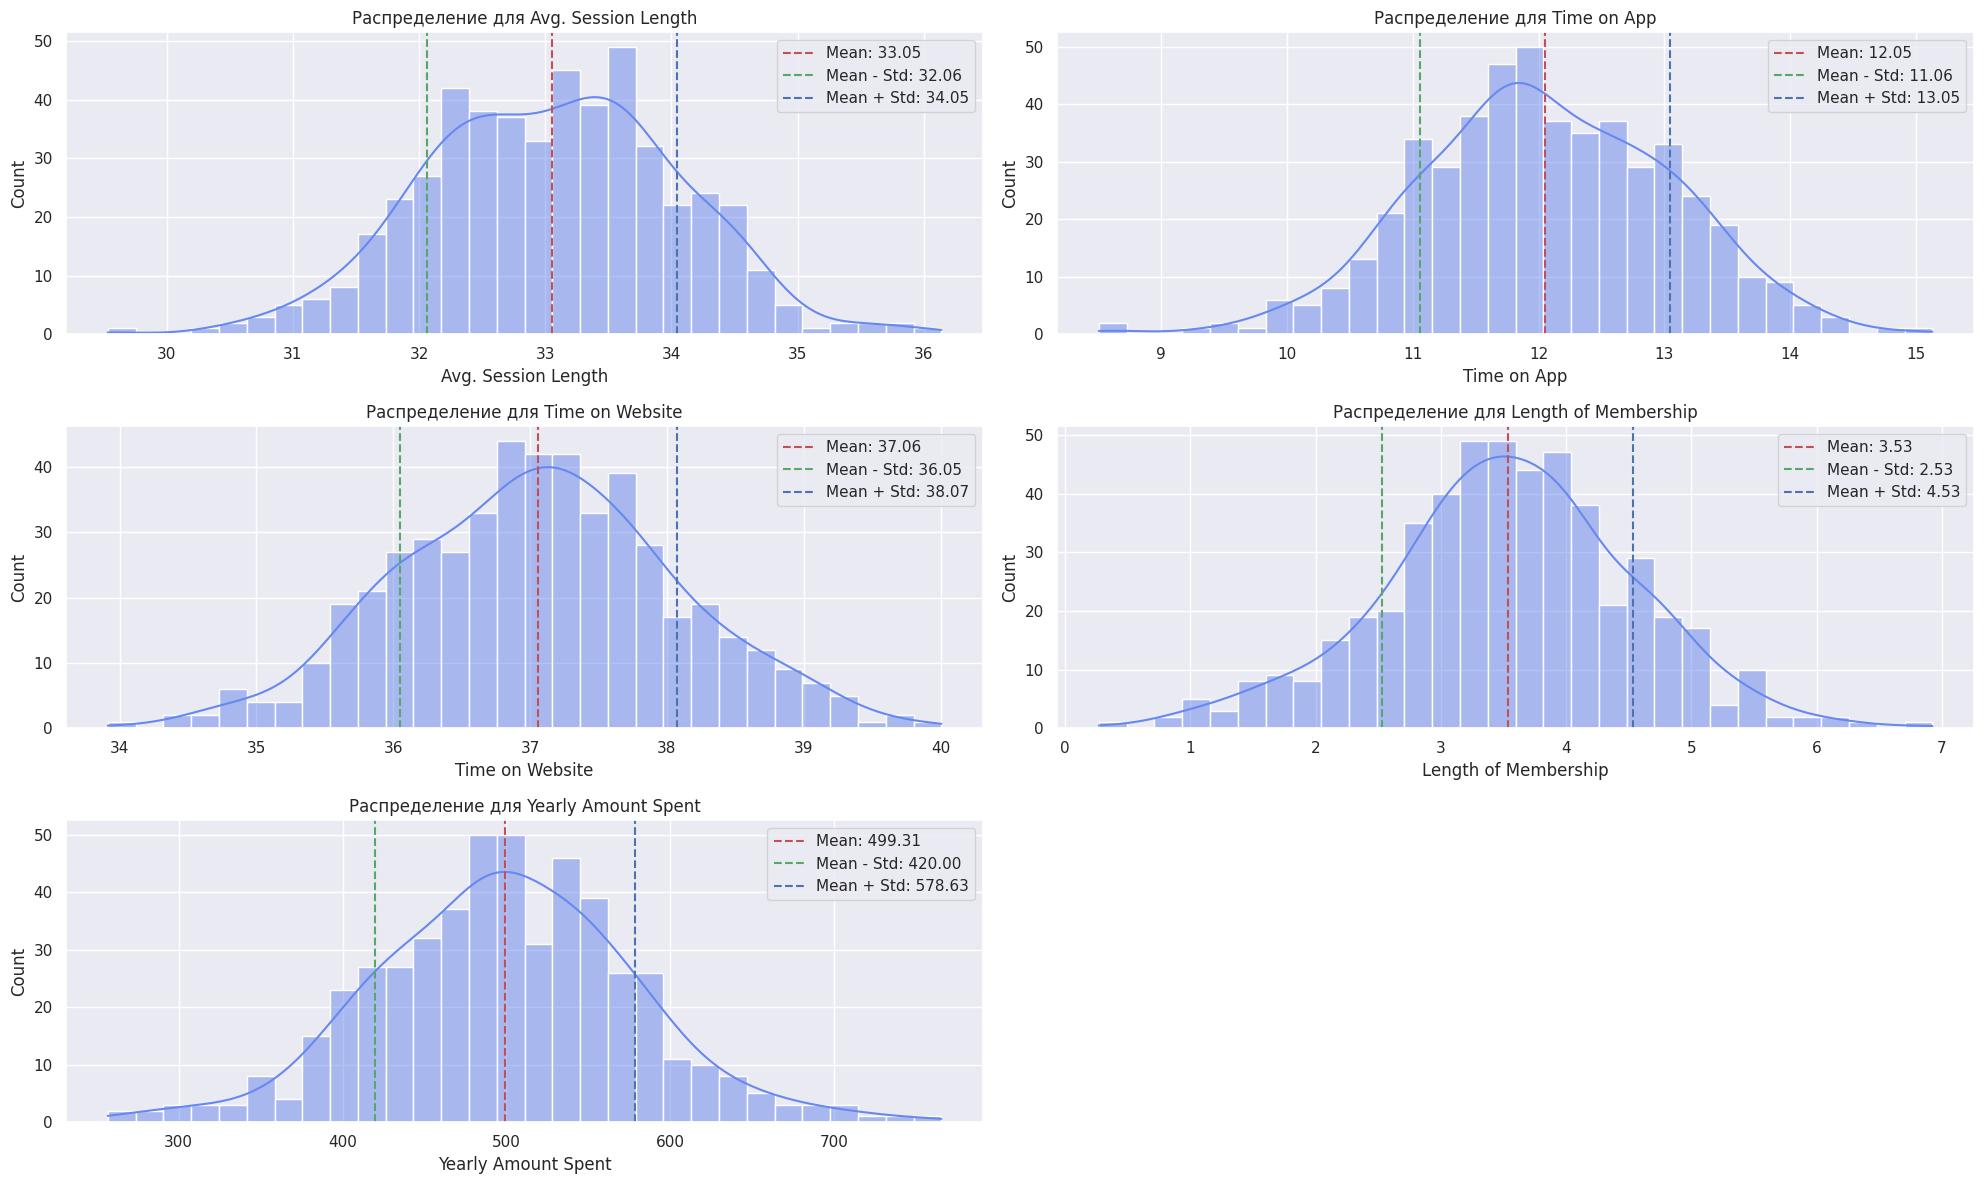

In [80]:
# посмотрим на распределения
num_cols = find_numeric_cols(df)
plot_numerical_distributions(df, num_cols)

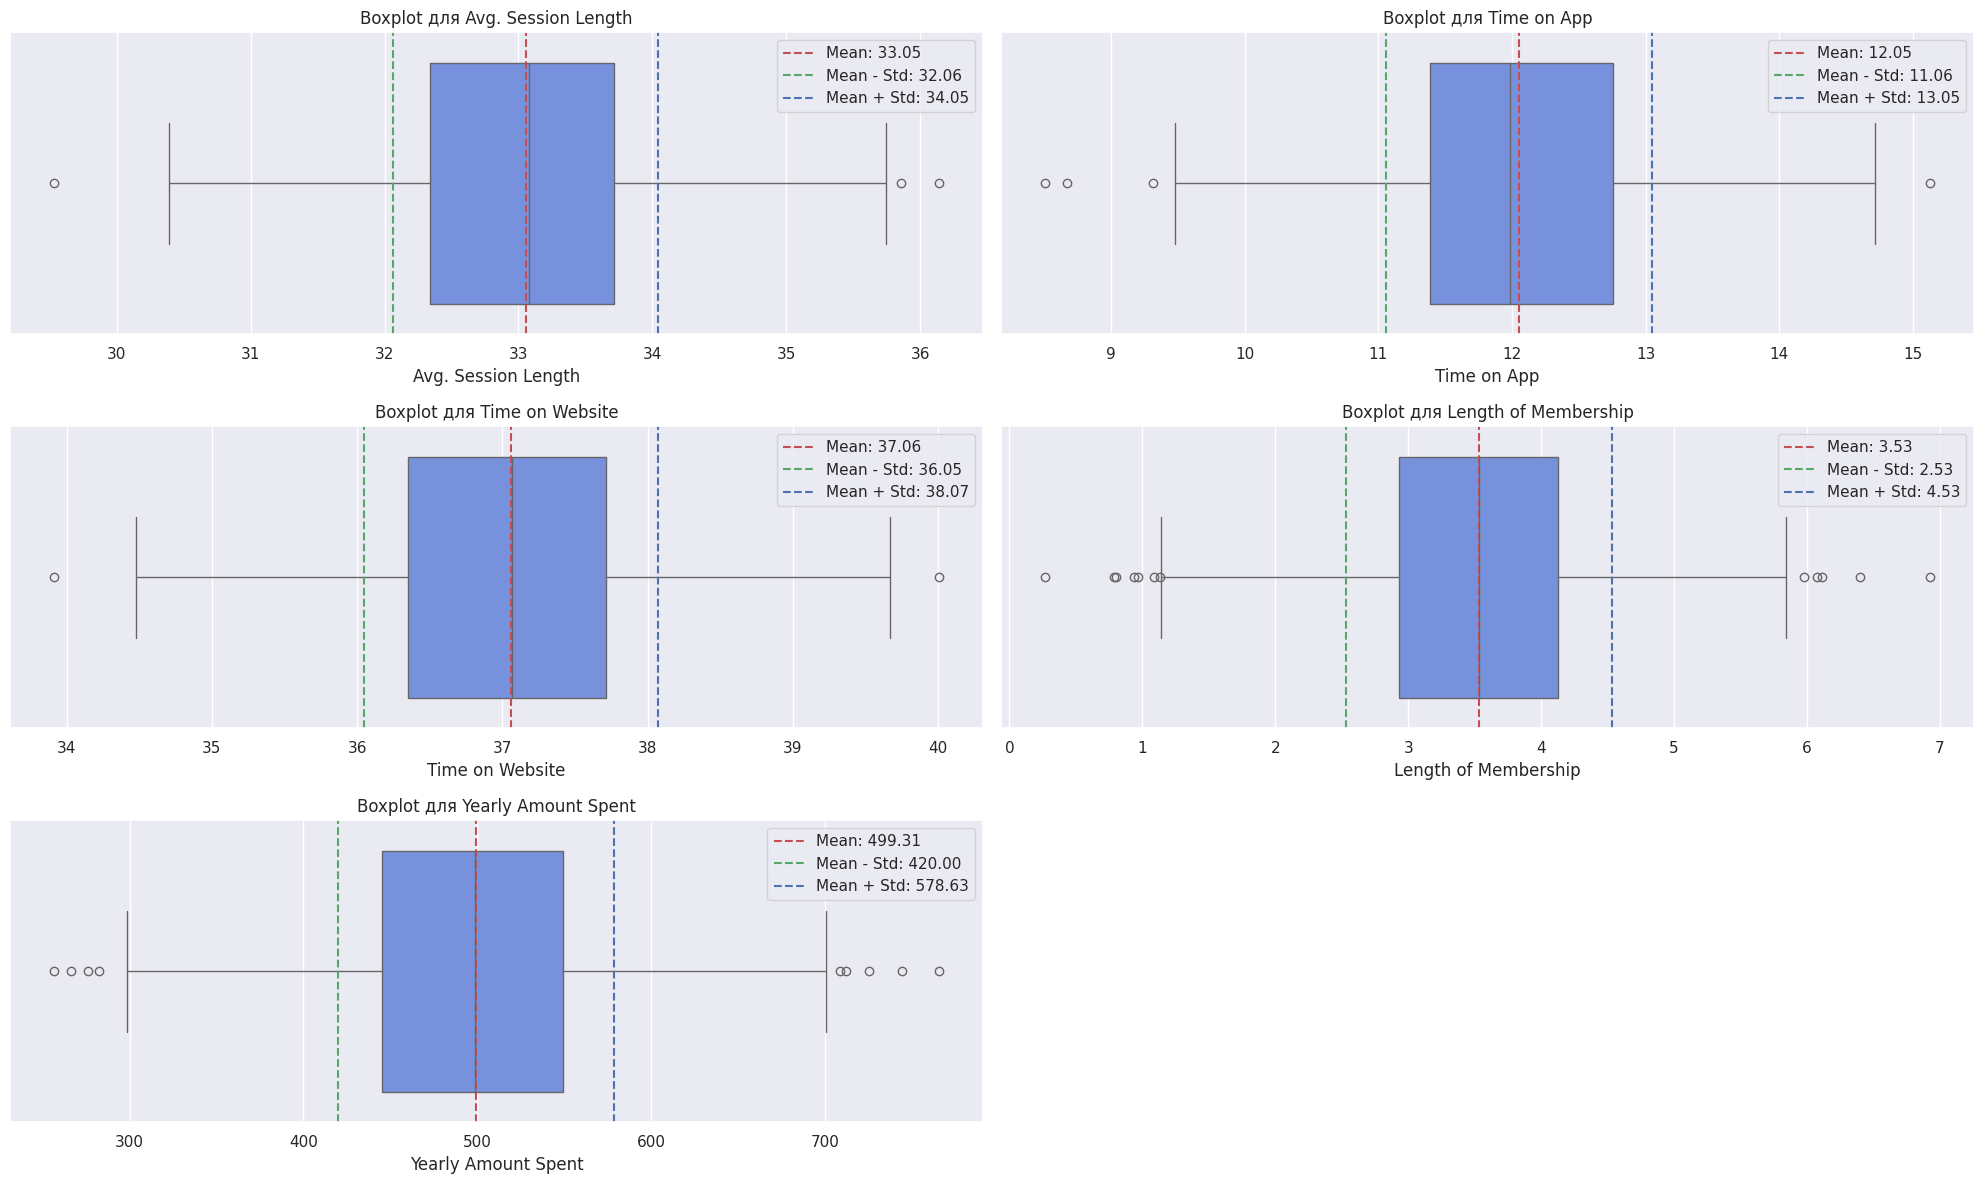

In [81]:
# боксплоты
plot_boxplots(df, num_cols)

In [82]:
# посмотрим на количество выбросов
outliers = find_outliers(df, num_cols)

Кол-во выбросов в колонке Avg. Session Length: 3
Кол-во выбросов в колонке Time on App: 4
Кол-во выбросов в колонке Time on Website: 2
Кол-во выбросов в колонке Length of Membership: 12
Кол-во выбросов в колонке Yearly Amount Spent: 9


Судя по графикам можно понять, что выбросы не являются результатом ошибки (опечатки) и могут отражать реальные особенности работы стилистов.

- **Avg. Session Length:** Затянувшиеся офлайн-сессии могут быть вызваны продлением времени консультации или сложностью кейса. В целом задержка в 5 минут - нормальная ситуация.

- **Time on App, Time on Website:** Продолжительное время в приложении или на сайте может указывать на активных пользователей, которые интенсивно используют его возможности, короткие сеансы - наоборот на пассивность, приоритет к офлайн-услугам или предпочтение к одной платформе (используют только сайт или только приложение). Аналогично это может указывать на технические проблемы пользователя (плохая связь), либо на индивидуальную скорость использования техники, тем не менее, эти пользователи также могут приносить прибыль.

- **Length of Membership:** новые и очень лояльные клиенты (тоже относятся к выбросам) также важны для анализа, возможно, они по-разному используют услуги компании и влияют на выручку.

- **Yearly Amount Spent:** высокие годовые траты могут быть у активных или премиум клиентов.

Нет нулевых значений, значит все клиенты выборки пользуются и сайтом, и приложением и офлайн сессиями. Скорее всего, это связано с тем, что компания предоставила данные только по участником программы лояльности, которые уже заинтересованы в продукте. Но можно отметить и то, что компания достаточно неплохо проработала путь клиента и кросс-платформенную модель удержания внимания.

Поэтому избавляться от выбросов мы не будем.

***Общие выводы по анализу числовых признаков:***

1. **Avg. Session Length**:
  - В среднем продолжительность офлайн-консультации со стилистом составляет около 33 минут с небольшим стандартным отклонением в 1 минуту. Это может значить, что время офлайн-сессии достаточно стандартизировано, возможно есть услуга "пол часа со стилистом".
  - Стандартизированная длина сессий может оказаться бесполезной для предсказательной модели, так что нам нужно будет внимательнее изучить этот признак и, возможно, удалить его.*

2. **Time on App**:
  - Среднее время использования приложения составляет около 12 минут (+- 1 минута), от минимального в 8.5 минут до максимального 15 минут.
  - Распределение близко к нормальному. Наблюдаются отдельные выбросы, которые  превышают среднее время использования приложения, но их не много.

- **Time on Website**:
  - Время, проведенное на сайте, показывает более широкий разброс значений по сравнению с временем в приложении, с средними значениями в районе 36-38 минут.
  - Боксплот не показывает значительных выбросов, что может говорить о более стабильном поведении пользователей на веб-сайте, чем в приложении.

- **Length of Membership**:
  - Длительность членства варьируется от нескольких месяцев до 7 лет, с медианой и средним около 3.5 лет, что говорит о сбалансированности распределения членства (равномерная воронка)
  - Боксплот выявляет выбросы с очень длительным членством, что может свидетельствовать о наличии особенно лояльной клиентской базы, но и число выбросов с небольшим сроком участия в программе лояльности говорит о том, что компания постоянно привлекает новых клиентов и работает над удержанием старых.

- **Yearly Amount Spent**:
  - Годовые траты клиентов варьируются от $256.70 до $765.50 с средним около $500.
  - Распределение средних годовых трат приближается к нормальному, но с некоторыми выбросами с высокими расходами.

***Анализ корреляций***

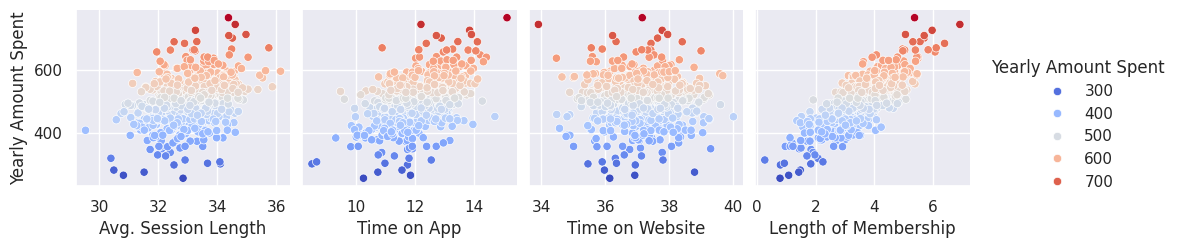

In [83]:
y_vars = 'Yearly Amount Spent'
x_vars = [col for col in num_cols if col != y_vars]
sns.pairplot(df, x_vars=x_vars, y_vars=y_vars, kind='scatter', hue='Yearly Amount Spent', palette='coolwarm')
plt.show()

Наиболее сильная линейная связь с целевой переменной наблюдается у Time on App и Length of Membership

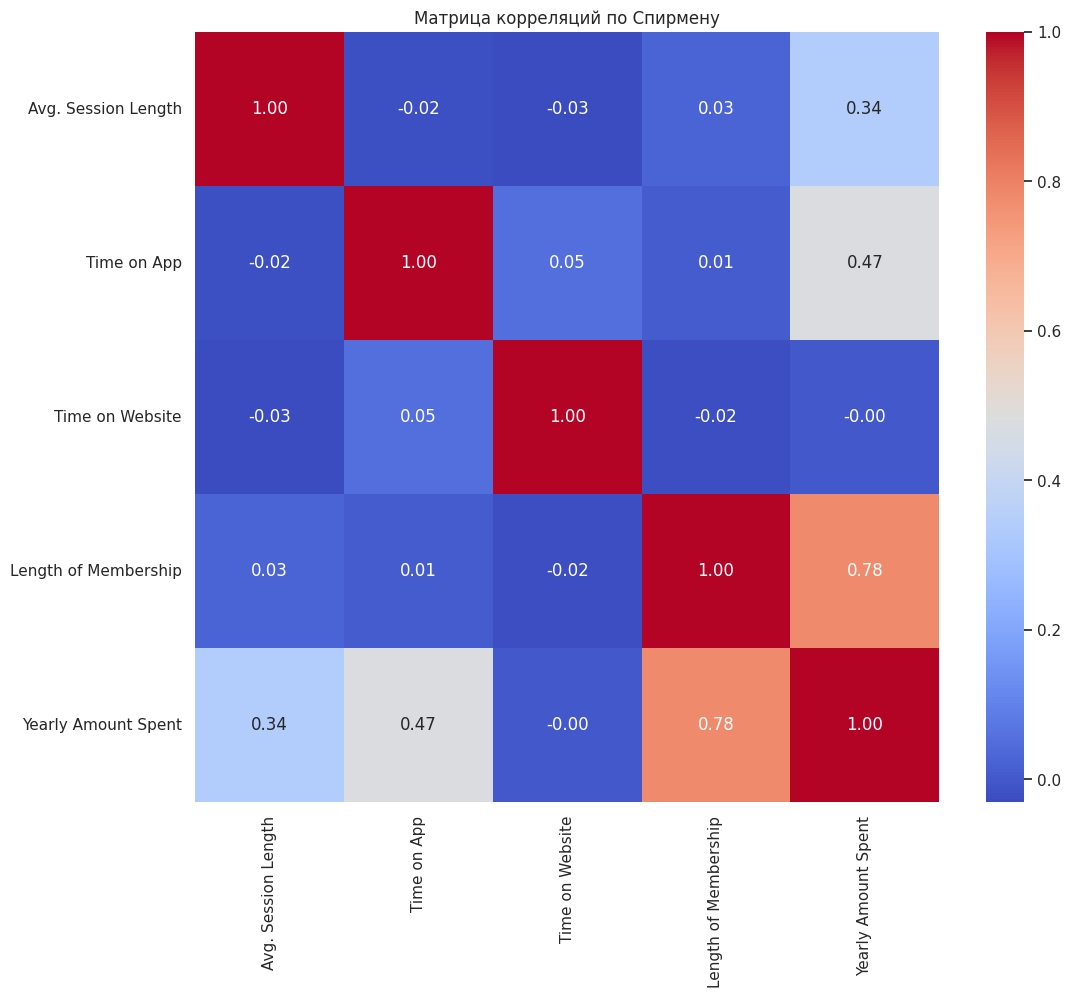

In [84]:
plot_spearman_correlation_matrix(df[num_cols])

Из данных графиков и тепловой карты можно сделать несколько выводов:

- **"Avg. Session Length vs. Yearly Amount Spent"** (0,34) явно выраженной корреляции не наблюдается, расходы распределены относительно равномерно независимо от длительности сессии.
- **"Time on App vs. Yearly Amount Spent"** (0,47) видна более чёткая положительная корреляция: увеличение времени, проведённого в приложении, связано с увеличением годовых расходов клиентов. Это может указывать на *эффективность приложения в привлечении клиентов к покупкам или на большую вовлечённость пользователей приложения в сервисы компании.*
- **"Length of Membership vs. Yearly Amount Spent"** (0,78) чётко видна сильная положительная корреляция: *чем дольше клиенты остаются с компанией, тем выше их годовые расходы.*

До этого мы уже отмечали, что признак Avg. Session Length является стандартизированным признаком (сессия около 30 минут), и его слабая корреляция с целевым признаком подтверждает, что мы можем убрать его из списка признаков для обучения. Но пока мы оставим его для построения baseline-модели, окончательное решение примем позже.

In [85]:
cols_to_drop = ['Yearly Amount Spent'] # сразу исключим целевой признак

# функция для добавления названия колонки в список для исключения из обучающих признаков
def columns_to_drop(*cols):
    for col in cols:
        cols_to_drop.append(col)

# columns_to_drop('Avg. Session Length')
cols_to_drop

['Yearly Amount Spent']

### Анализ и обработка категориальных признаков

In [86]:
cat_cols = find_categorical_cols(df)
for col in cat_cols:
    print(f"Кол-во уникальных значений в столбце {col}: {df[col].nunique()}")

Кол-во уникальных значений в столбце Email: 500
Кол-во уникальных значений в столбце Address: 500
Кол-во уникальных значений в столбце Avatar: 138


Столбец Email является уникальным для каждого клиента и не поможет нам при разработке предсказательной модели, так что можем не включать его в список свободных признаков.

In [87]:
columns_to_drop('Email')
cols_to_drop

['Yearly Amount Spent', 'Email']

In [88]:
df['Address'].sample(10)

485    07813 Randy Point\nLake Thomasberg, MO 06013-9920
120            26737 Brooks Roads\nVincentstad, VA 93089
20             84426 Julia Vista\nNorth Teresa, KY 50756
444    189 Crawford Hill Apt. 746\nNew Madison, WV 14...
432    685 Sexton Ranch Suite 125\nLake Robertshire, ...
113         3144 Jamie Rest\nMaxwellville, NC 93749-1190
419    210 Johnson Street Suite 717\nNew Bethanyborou...
221          36192 Ho Spring\nNew Michael, RI 65851-6369
435       257 Hunt Manors\nSouth Charlottefort, CT 15033
52     861 Annette Stream Suite 771\nNorth Miguel, CA...
Name: Address, dtype: object

Адрес тоже является уникальным, но для нас может оказаться важным город и штат, в котором живет клиент, так как могут наблюдаться какие-либо особенности в доходах и образе жизни, попробуем создать новые признаки - город и штат и тогда сможем удалить признак 'Address', который сам по себе не несет ценности для дальнейшего анализа.

Для извлечения города и штата из адреса рассмотрим шаблон написания. Можем заметить 2 формата адреса:

1. Обычный адрес: [835 Frank Tunnel]\n[**Wrightmouth, MI**] [82180-9605]

= [адрес] \n **[город, штат]** [индекс] (город и штат через запятую)
2. Дипломатический или армейский: [USCGC Thomas]\n[**FPO**] [**AP**] [43708-2468]

= [объект]\n[**сервис**] [**регион**][индекс] (через пробел)

In [89]:
# функция для извлечения города и штата в отдельные колонки
def extract_city_region(address):
    if ' AP ' in address or ' AA ' in address or ' AE ' in address:
      city = address.split('\n')[1].split(' ')[0]
      region = address.split('\n')[1].split(' ')[1]
    else:
        # для гражданских адресов
        city = address.split('\n')[1].split(',')[0]
        region = address.split('\n')[1].split(',')[1].split(' ')[1]
    return city, region

# применяем функцию и создаем новые столбцы 'City' и 'State'
df['City'], df['Region'] = zip(*df['Address'].apply(lambda x: extract_city_region(x)))

In [90]:
df.sample(5)

,Email,Address,Avatar,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent,City,Region
373,tanya20@gmail.com,"69279 Stewart Mountains\nSouth Pamela, KS 2254...",DarkKhaki,31.366212,11.163160,37.088319,3.620355,430.588883,South Pamela,KS
48,dongarcia@hotmail.com,"546 Benjamin Lights Suite 421\nRomerofurt, NC ...",MediumBlue,33.117219,11.864126,36.582728,3.202531,479.731949,Romerofurt,NC
434,jordandavid@gmail.com,"61502 Parker Vista Apt. 363\nJonesshire, GU 33532",Violet,33.666616,10.985764,36.352503,0.936498,304.135592,Jonesshire,GU
390,michaelcampbell@yahoo.com,"96480 White Lane Suite 521\nPattersonhaven, OR...",Gray,35.860237,11.730661,36.882149,3.416210,546.556667,Pattersonhaven,OR
167,turnerryan@hotmail.com,"770 Lewis Pike Apt. 869\nPhelpsport, PA 93969-...",LightSkyBlue,34.046638,12.474455,35.037856,4.055776,578.986259,Phelpsport,PA


In [91]:
print(f"Всего городов: {df['City'].nunique()}")
print(f"Всего регионов: {df['Region'].nunique()}")

Всего городов: 449
Всего регионов: 62


Мы получили 449 различных городов при 500 записях в датасете. Это говорит о том, что большинство городов встречаются в датасете всего 1 раз, что никак не поможет нам в построении предсказательной модели. Поэтому мы не будем использовать признак City для обучения.

In [92]:
df['Region'].unique()

array(['MI', 'CA', 'DC', 'OH', 'PR', 'MN', 'WV', 'AP', 'SD', 'AA', 'WY',
       'MO', 'MP', 'ND', 'GA', 'PW', 'MT', 'KY', 'AE', 'VI', 'TX', 'MS',
       'SC', 'WA', 'NJ', 'NH', 'ME', 'ID', 'TN', 'AK', 'DE', 'FM', 'HI',
       'KS', 'NC', 'UT', 'AL', 'LA', 'NE', 'OR', 'CT', 'MA', 'IN', 'AZ',
       'MH', 'NY', 'CO', 'IA', 'GU', 'AS', 'RI', 'VA', 'MD', 'OK', 'WI',
       'VT', 'FL', 'IL', 'NV', 'PA', 'NM', 'AR'], dtype=object)

Регионов также много, попробуем сгруппировать их. В США штаты часто группируются в следующие регионы:

- Северо-Восточный (Northeast)
- Средний Запад (Midwest)
- Юг (South)
- Запад (West)

Кроме того, в списке присутствуют специальные региональные коды, такие как 'AP' (Armed Forces Pacific), 'AA' (Armed Forces Americas), 'AE' (Armed Forces Europe), которые могут быть сгруппированы в отдельную категорию

In [93]:
# функция для группировки регионов

def region_group(region):
    northeast = {'ME', 'NH', 'VT', 'MA', 'RI', 'CT', 'NY', 'NJ', 'PA'}
    midwest = {'OH', 'MI', 'IN', 'WI', 'IL', 'MN', 'IA', 'MO', 'ND', 'SD', 'NE', 'KS'}
    south = {'DE', 'MD', 'DC', 'VA', 'WV', 'NC', 'SC', 'GA', 'FL', 'KY', 'TN', 'MS', 'AL', 'OK', 'TX', 'AR', 'LA', 'PR'}
    west = {'ID', 'MT', 'WY', 'NV', 'UT', 'CO', 'AZ', 'NM', 'AK', 'WA', 'OR', 'CA', 'HI'}
    military_overseas = {'AP', 'AA', 'AE', 'MP', 'GU', 'AS', 'VI', 'PW', 'FM', 'MH'}

    # проверка региона и присвоение соответствующей группы
    if region in northeast:
        return 'Northeast'
    elif region in midwest:
        return 'Midwest'
    elif region in south:
        return 'South'
    elif region in west:
        return 'West'
    elif region in military_overseas:
        return 'Military'
    else:
        return 'Other'  # для всех неизвестных или новых регионов

df['Region Group'] = df['Region'].apply(region_group)
df['Region Group'].value_counts()

Region Group
South        149
Midwest       98
Military      93
West          87
Northeast     73
Name: count, dtype: int64

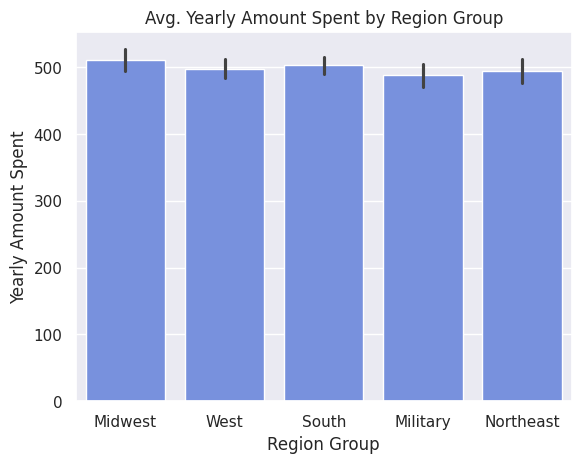

In [94]:
# посмотрим на средние годовые затраты для каждого типа адреса
sns.barplot(x='Region Group', y='Yearly Amount Spent', data=df)
plt.title('Avg. Yearly Amount Spent by Region Group')
plt.show()

In [95]:
# теперь можем исключить колонки 'Address', 'City' и 'Region'
columns_to_drop('Address', 'City', 'Region')
cols_to_drop

['Yearly Amount Spent', 'Email', 'Address', 'City', 'Region']

In [96]:
print(df['Avatar'].nunique())
df['Avatar'].unique()

138


array(['Violet', 'DarkGreen', 'Bisque', 'SaddleBrown', 'MediumAquaMarine',
       'FloralWhite', 'DarkSlateBlue', 'Aqua', 'Salmon', 'Brown',
       'Tomato', 'RoyalBlue', 'DarkBlue', 'Peru', 'PowderBlue',
       'OliveDrab', 'Cyan', 'LightSeaGreen', 'PeachPuff', 'Black',
       'Olive', 'Silver', 'Wheat', 'Teal', 'Linen', 'MediumSlateBlue',
       'LemonChiffon', 'DarkOrchid', 'SeaGreen', 'SteelBlue',
       'DarkMagenta', 'DarkGoldenRod', 'DarkSeaGreen', 'Gainsboro',
       'HotPink', 'HoneyDew', 'WhiteSmoke', 'GhostWhite', 'Chocolate',
       'Snow', 'BurlyWood', 'Moccasin', 'BlueViolet', 'MediumBlue',
       'GreenYellow', 'SandyBrown', 'MediumVioletRed', 'DarkOliveGreen',
       'DarkSalmon', 'DeepPink', 'SkyBlue', 'Magenta', 'DarkTurquoise',
       'SpringGreen', 'OrangeRed', 'LimeGreen', 'LightGreen',
       'LightYellow', 'MintCream', 'DimGray', 'Indigo', 'LightSalmon',
       'DeepSkyBlue', 'Turquoise', 'LightSteelBlue', 'Cornsilk',
       'DarkKhaki', 'FireBrick', 'SlateGray',

Колонка Avatar содержит 138 уникальных значений, что делает её высококардинальной. Обработка такого большого количества уникальных категорий может привести к избыточности и затруднить обучение моделей.

Каждый цвет в Avatar мог быть выбран произвольно или по эстетическим предпочтениям пользователя, не связанным с его поведенческими паттернами или решениями. *Лучше не использовать этот признак в обучении на данном этапе.*

In [97]:
columns_to_drop('Avatar')
cols_to_drop

['Yearly Amount Spent', 'Email', 'Address', 'City', 'Region', 'Avatar']

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Email                 500 non-null    object 
 1   Address               500 non-null    object 
 2   Avatar                500 non-null    object 
 3   Avg. Session Length   500 non-null    float64
 4   Time on App           500 non-null    float64
 5   Time on Website       500 non-null    float64
 6   Length of Membership  500 non-null    float64
 7   Yearly Amount Spent   500 non-null    float64
 8   City                  500 non-null    object 
 9   Region                500 non-null    object 
 10  Region Group          500 non-null    object 
dtypes: float64(5), object(6)
memory usage: 43.1+ KB


# Моделирование

Вам необходимо:

3) Изучить взаимосвязь признаков с целевой переменной.

4) На основе взаимосвязей выбрать и построить модель, прогнозирующую годовую сумму трат клиента.

5) Оценить модель. Построить точечный график прогнозных значений относительно фактических и оценить метрику качества (выберите её самостоятельно).

6) Написать выводы на основе интерпретации результатов модели: что сильнее влияет на доход компании? Сформировать краткие рекомендации.

Сопровождайте все действия, которые могут предполагать альтернативные способы реализации, обоснованием.


## Функции для моделирования

In [99]:
# 1. функция для оценки модели на кросс-валидации и печать результатов
def evaluate_model(model, X, y, n_splits=5, random_state=42):
    """
    Оценивает модель с помощью кросс-валидации и возвращает средние значения метрик.

    Args:
    model (model object): Модель для оценки.
    X (DataFrame): Признаки для обучения.
    y (Series): Целевая переменная.
    n_splits (int): Количество фолдов для кросс-валидации.
    random_state (int): Сид для воспроизводимости результатов.

    Returns:
    dict: Словарь с средними значениями метрик MAE, MSE и R².
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    scoring = {'MAE': 'neg_mean_absolute_error', 'MSE': 'neg_mean_squared_error', 'R2': 'r2'}
    scores = cross_validate(model, X, y, cv=kf, scoring=scoring, return_train_score=False)

    # расчет средних значений метрик
    results = {
        'MAE': -scores['test_MAE'].mean(),
        'MSE': -scores['test_MSE'].mean(),
        'R2': scores['test_R2'].mean()
    }

    # печать результатов
    print(f"{model.__class__.__name__} results:")
    print(f"Средняя абсолютная ошибка (MAE): {results['MAE']:.2f}")
    print(f"Среднеквадратичная ошибка (MSE): {results['MSE']:.2f}")
    print(f"Средний коэффициент детерминации (R²): {results['R2']:.2f}")

    return results


# 2. функция для визуализации результатов
def visualize_results(y_test, predictions, model_name):
    """
    Визуализирует результаты предсказаний модели.

    Args:
    y_test (Series): Фактические значения целевой переменной.
    predictions (array): Предсказанные значения модели.
    model_name (str): Название модели для заголовка графика.
    """
    # график сравнения фактических и предсказанных значений
    plt.figure(figsize=(10, 8))
    plt.scatter(y_test, predictions, alpha=0.7, label='Predictions vs Actual data')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal')
    plt.xlabel('Фактические значения')
    plt.ylabel('Предсказанные значения')
    plt.title(f'Сравнение фактических и предсказанных значений ({model_name})')
    plt.legend()
    plt.grid(True)
    plt.show()

    # график остатков
    residuals = y_test - predictions
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title(f'Распределение остатков ({model_name})')
    plt.xlabel('Остатки (фактические - предсказанные)')
    plt.ylabel('Частота')
    plt.grid(True)
    plt.show()

# 3. добавить результаты в итоговую таблицу
def add_results(results_df, model_name, model_results):
    """
    Добавляет новую строку с результатами модели в DataFrame результатов.

    Args:
        results_df (DataFrame): DataFrame с текущими результатами.
        model_name (str): Название модели.
        model_results (dict): Словарь с результатами модели.

    Returns:
        DataFrame: Обновленный DataFrame с новыми результатами.
    """
    new_row = pd.DataFrame({
        'Model': [model_name],
        'MAE': [model_results['MAE']],
        'MSE': [model_results['MSE']],
        'R²': [model_results['R2']]
    })
    return pd.concat([results_df, new_row], ignore_index=True)

## 1. Baseline-модель лин. регрессия

In [100]:
# определим целевую переменную и свободные признаки
X = df.drop(cols_to_drop, axis=1)
y = df['Yearly Amount Spent']
# разделим данные на тренировочный и тествовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [101]:
print(f'Размер X_train: {X_train.shape}')
print(f'Размер X_test: {X_test.shape}')
print(f'Размер y_train: {y_train.shape}')
print(f'Размер y_test: {y_test.shape}')

Размер X_train: (400, 5)
Размер X_test: (100, 5)
Размер y_train: (400,)
Размер y_test: (100,)


In [102]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Avg. Session Length   500 non-null    float64
 1   Time on App           500 non-null    float64
 2   Time on Website       500 non-null    float64
 3   Length of Membership  500 non-null    float64
 4   Region Group          500 non-null    object 
dtypes: float64(4), object(1)
memory usage: 19.7+ KB


Для baseline-модели исключим категориальные признаки, так как модель не распознает их без кодирования.


In [103]:
from sklearn.linear_model import LinearRegression

cat_cols_X = find_categorical_cols(X_train)
X_train_base = X_train.drop(cat_cols_X, axis=1)
X_test_base = X_test.drop(cat_cols_X, axis=1)

# обучение и оценка лин. регрессии
baseline_model = LinearRegression()
baseline_results = evaluate_model(baseline_model, X_train_base, y_train)

LinearRegression results:
Средняя абсолютная ошибка (MAE): 7.83
Среднеквадратичная ошибка (MSE): 98.61
Средний коэффициент детерминации (R²): 0.98


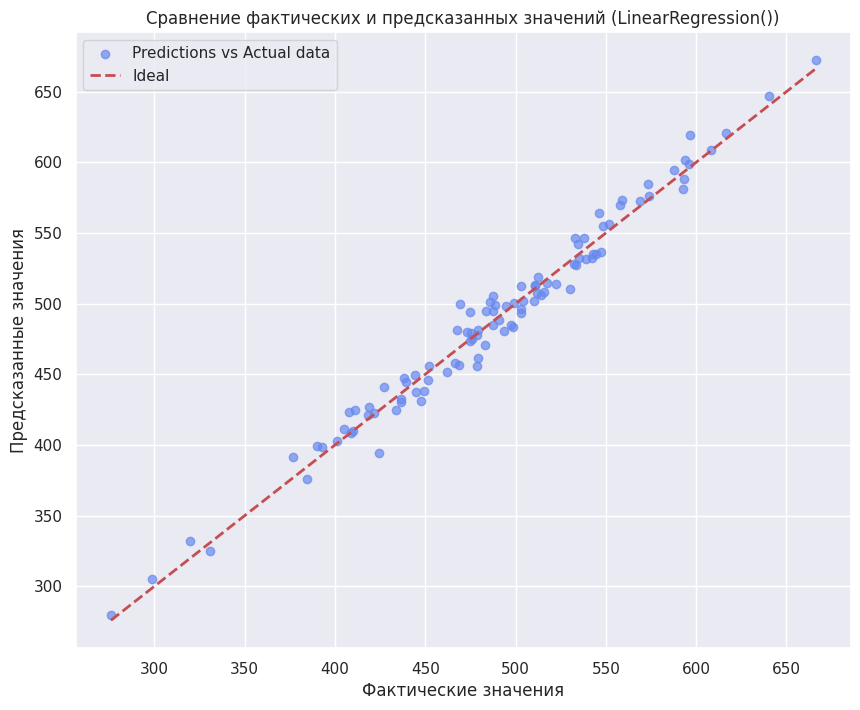

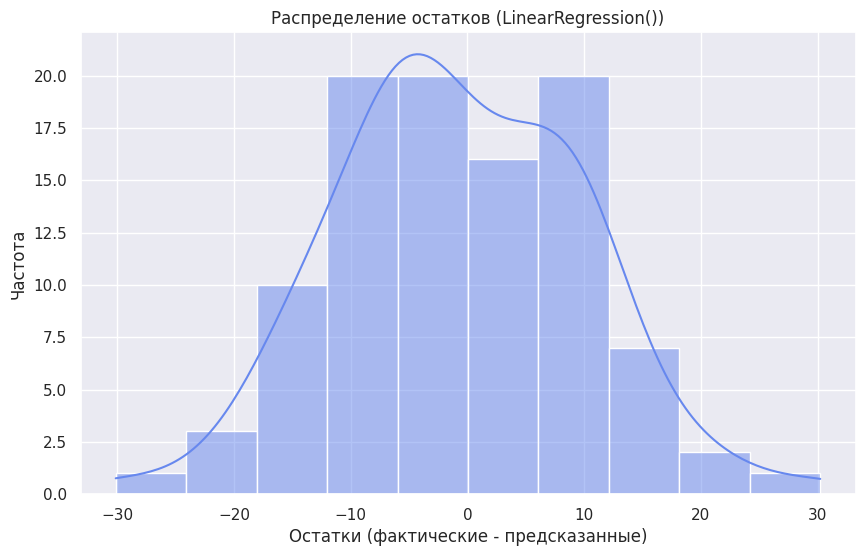

In [104]:
# визуализация результатов
baseline_model.fit(X_train_base, y_train)
y_pred_base = baseline_model.predict(X_test_base)
visualize_results(y_test, y_pred_base, baseline_model)

Базовая модель линейной регрессии достаточно хорошо справляется с задачей прогнозирования годовых трат клиентов интернет-магазина, что подтверждается значением коэффициента детерминации (R²) равным 0.88. Точки рассеяния на графике лежат вдоль линии регрессии и близки к ней, а большинство остатков сосредоточены вокруг нуля. Это также может говорить о хорошей предсказательной способности модели.

Однако, судя по графику остатков, мы видим ассиметрию в данных и выбросы (остатки выше 40). Поэтому для дальнейшего моделирования лучше масштабировать данные.

In [105]:
baseline_test_results = evaluate_model(baseline_model, X_test_base, y_test)

LinearRegression results:
Средняя абсолютная ошибка (MAE): 8.48
Среднеквадратичная ошибка (MSE): 109.22
Средний коэффициент детерминации (R²): 0.97


In [106]:
print(baseline_results)
print(baseline_test_results)

{'MAE': 7.8314747533413875, 'MSE': 98.61322047597568, 'R2': 0.9847554859011227}
{'MAE': 8.482252183166976, 'MSE': 109.2151352137741, 'R2': 0.9746604866123713}


Модель показывает отличные результаты и на тестовых данных, значит, вероятность того, что модель переобучилась низкая.

In [107]:
# создадим таблицу для сохранения результатов
results = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'R²'])
results

,Model,MAE,MSE,R²


In [108]:
results = add_results(results, 'Baseline Linear Regression', baseline_results)
results

,Model,MAE,MSE,R²
0,Baseline Linear Regression,7.831475,98.61322,0.984755


## Кодирование и масштабирование признаков

1. Мы имеем категориальный признак 'Region Group', закодируем его методом One-Hot Encoding.

2. Числовые признаки имеют выбросы, что может плохо сказаться на предсказательной способности модели. Проведем масштабирование с помощью Standard Scaler.

In [109]:
# создадим пайплайн для предобработки данных (кодирование + масштабирование)

def apply_preprocessing(numerical_features, categorical_features, X_train, X_test):
    """
    Создает и применяет преобразования к данным обучения и тестирования.

    Определяет отдельные трансформеры для числовых и категориальных признаков.
    Числовые признаки стандартизируются, а категориальные кодируются с использованием OneHotEncoder.
    Функция автоматически применяет эти преобразования к переданным наборам данных обучения и тестирования.

    Параметры:
    numerical_features (list): Список имен числовых столбцов для масштабирования.
    categorical_features (list): Список имен категориальных столбцов для кодирования.
    X_train (DataFrame): Данные для обучения.
    X_test (DataFrame): Данные для тестирования.

    Возвращает:
    X_train_transformed (DataFrame): Преобразованные данные обучения.
    X_test_transformed (DataFrame): Преобразованные данные тестирования.
    """
    numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # применение преобразований
    X_train_transformed = preprocessor.fit_transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)

    # соединим обработанные числовые и категориальные признаки
    new_columns = (numerical_features +
                    list(preprocessor.named_transformers_['cat'].named_steps['onehot']
                    .get_feature_names_out(categorical_features)))

    # переведем закодированные признаки обратно в DF с правильными именами
    X_train_transformed = pd.DataFrame(X_train_transformed, columns=new_columns, index=X_train.index)
    X_test_transformed = pd.DataFrame(X_test_transformed, columns=new_columns, index=X_test.index)

    return X_train_transformed, X_test_transformed

In [110]:
numerical_features = find_numeric_cols(X_train)
categorical_features = find_categorical_cols(X_train)

X_train_sc, X_test_sc = apply_preprocessing(numerical_features, categorical_features, X_train, X_test)
X_train_sc

,Avg. Session Length,Time on App,Time on Website,Length of Membership,Region Group_Midwest,Region Group_Military,Region Group_Northeast,Region Group_South,Region Group_West
249,0.728756,-0.140376,-0.173216,0.065197,0.0,1.0,0.0,0.0,0.0
433,1.233670,-0.235492,-0.700765,-1.413095,1.0,0.0,0.0,0.0,0.0
19,-0.449465,1.935961,0.166982,0.483620,0.0,0.0,0.0,0.0,1.0
322,0.206170,-1.328388,-0.860896,0.505068,0.0,0.0,1.0,0.0,0.0
332,0.084123,-0.321354,0.899668,-1.342230,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
106,-0.780032,0.133039,-0.854333,0.208220,1.0,0.0,0.0,0.0,0.0
270,0.958189,0.900460,1.607973,-0.284756,0.0,1.0,0.0,0.0,0.0
348,-1.265871,-1.173271,-2.088751,-0.428040,0.0,0.0,0.0,0.0,1.0
435,-0.812250,2.079565,0.002649,0.188979,0.0,0.0,1.0,0.0,0.0


Мы получили обновленные закодированные и  масштабированые данные X_train_sc и X_test_sc

Разработаем пайплайн для дальнейшего обучения и оценки моделей из заранее подготовленных нами функций.

## Пайплайн обучения

In [111]:
def run_pipeline(model, X_train, y_train, X_test, y_test, results_df, model_name):
    """
    Проводит полный цикл анализа с моделью: оценка, обучение, предсказание, визуализация и сохранение результатов.

    Args:
    model (model object): Модель для анализа.
    X_train (DataFrame): Данные для обучения.
    y_train (Series): Целевая переменная для обучения.
    X_test (DataFrame): Данные для тестирования.
    y_test (Series): Целевая переменная для тестирования.
    results_df (DataFrame): DataFrame для сохранения результатов.
    model_name (str): Название модели для отображения и сохранения результатов.

    Returns:
    DataFrame: Обновленный DataFrame с результатами.
    """
    # оценка модели на кросс-валидации
    model_results = evaluate_model(model, X_train, y_train)

    # обучение модели на полном наборе тренировочных данных
    model.fit(X_train, y_train)

    # предсказание на тестовом наборе
    predictions = model.predict(X_test)

    # визуализация результатов
    visualize_results(y_test, predictions, model_name)

    # добавление результатов в таблицу
    results_df = add_results(results_df, model_name, model_results)

    return results_df

## 2. Scaled Linear Regression

В предыдущем шаге ы получили обновленные закодированные и  масштабированые данные X_train_sc и X_test_sc. Обучим на них модель линейной регрессии

LinearRegression results:
Средняя абсолютная ошибка (MAE): 7.89
Среднеквадратичная ошибка (MSE): 100.29
Средний коэффициент детерминации (R²): 0.98


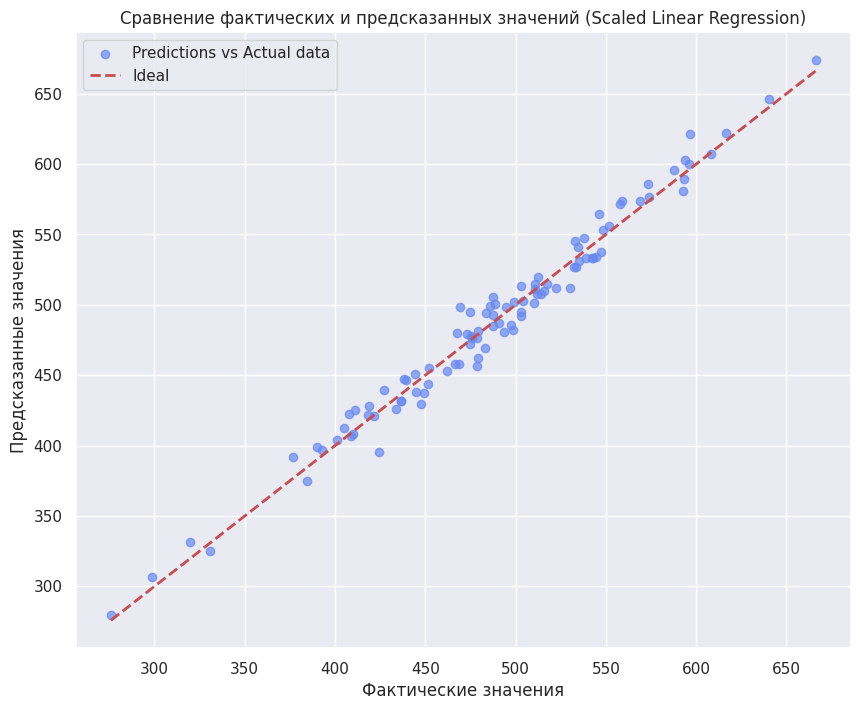

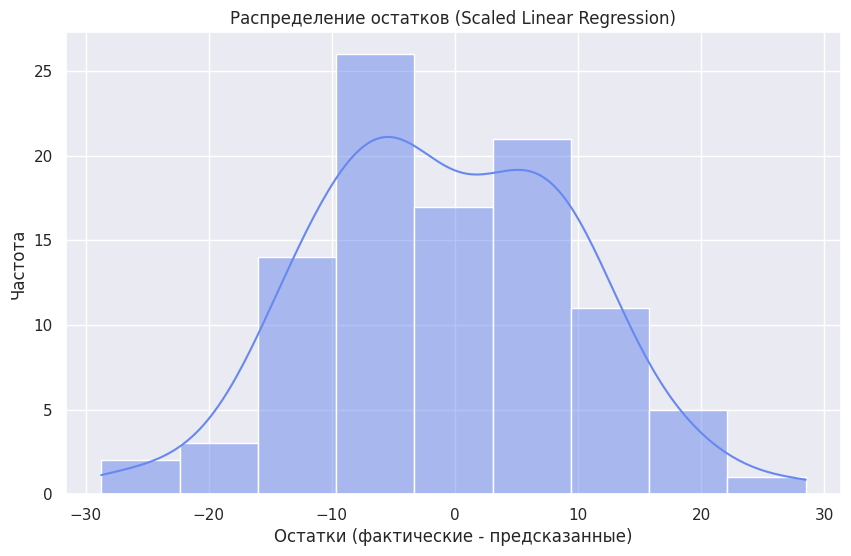

In [112]:
# обучим модель линейной регрессии с включением категориального признака и масштабированными данными
lin_reg_scaled = LinearRegression()
results = run_pipeline(lin_reg_scaled, X_train_sc, y_train, X_test_sc, y_test, results, 'Scaled Linear Regression')

**Основные результаты модели Scaled Linear Regression:**

- Средняя абсолютная ошибка (MAE): 7.89
- Среднеквадратичная ошибка (MSE): 100.29
- Коэффициент детерминации (R²): 0.98

**Анализ результатов:**

1. *Сравнение фактических и предсказанных значений:*
График показывает, что предсказанные значения очень близки к фактическим, большинство точек близко расположены к идеальной диагонали. Это указывает на высокую точность предсказаний модели.

2. *Распределение остатков:*
Распределение остатков близко к нормальному, что является хорошим знаком для линейной регрессии. Но наблюдается небольшая асимметрия влево, что может указывать на некоторые систематические ошибки в предсказаниях или на неучтенные данные, влияющие на результаты.

После обработки признаков качество модели немного ухудшилось в сравнении с бейзлайн моделью. Возможно, дело в том, что мы включили категориальные признаки, поэтому далее проведем **тест на важность признаков.**

In [113]:
results

,Model,MAE,MSE,R²
0,Baseline Linear Regression,7.831475,98.613220,0.984755
1,Scaled Linear Regression,7.892258,100.292574,0.984423


## 3. Random Forest

RandomForestRegressor results:
Средняя абсолютная ошибка (MAE): 14.95
Среднеквадратичная ошибка (MSE): 427.83
Средний коэффициент детерминации (R²): 0.94


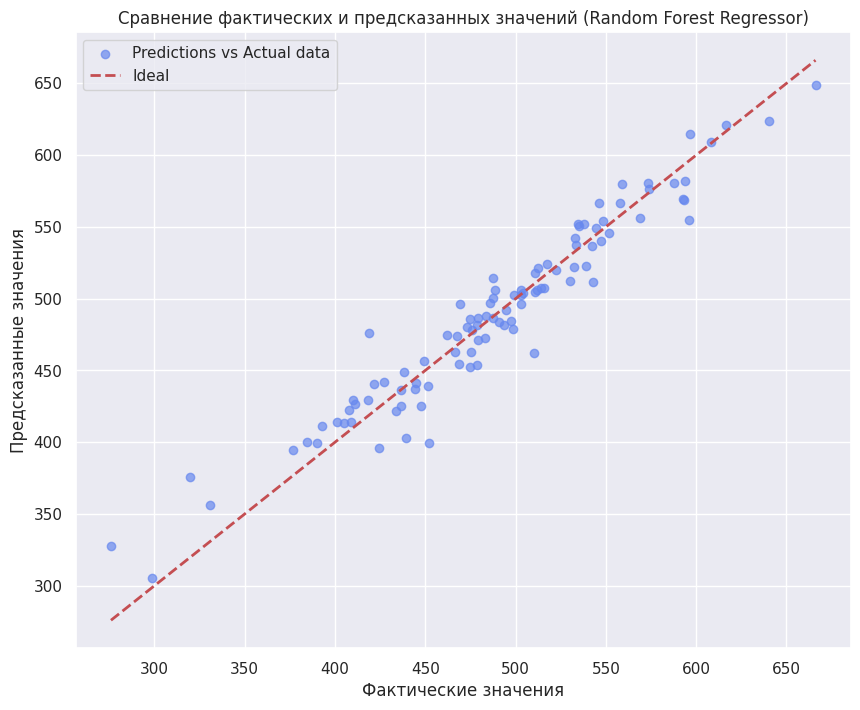

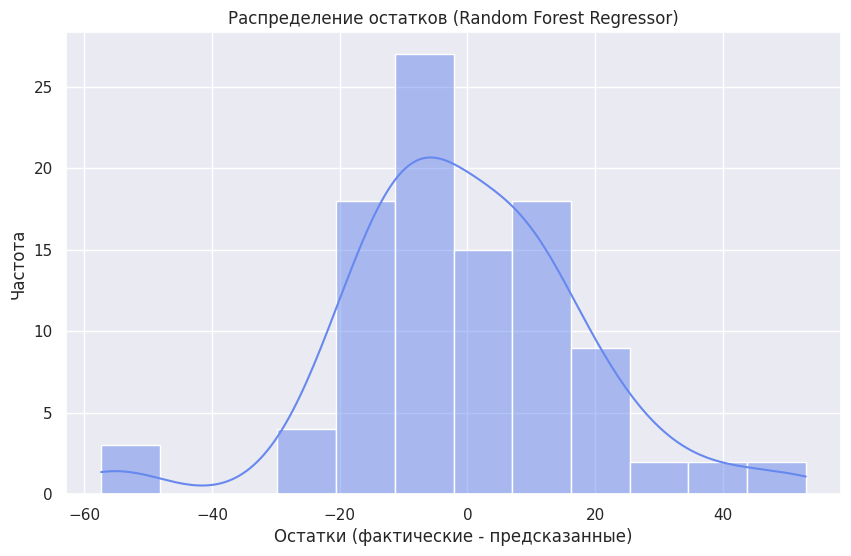

In [114]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42)
results = run_pipeline(rf_model, X_train_sc, y_train, X_test_sc, y_test, results, 'Random Forest Regressor')

In [115]:
# проведем анализ важности признаков

def analyze_feature_importance(model, feature_names):
    """
    Анализирует и визуализирует важность признаков для обученной модели случайного леса.

    Аргументы:
        model (RandomForestRegressor): Обученная модель случайного леса.
        feature_names (list): Список названий признаков, используемых в модели.

    Возвращает:
        features_df (DataFrame): DataFrame с признаками и их важностями, отсортированными по убыванию важности.
    """
    # получение массива важности признаков
    feature_importances = model.feature_importances_

    # создание DataFrame для удобства отображения
    features_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })

    # сортировка данных по важности
    features_df = features_df.sort_values(by='Importance', ascending=False)

    return features_df


                  Feature  Importance
3    Length of Membership    0.703478
1             Time on App    0.201553
0     Avg. Session Length    0.077963
2         Time on Website    0.010134
6  Region Group_Northeast    0.001679
7      Region Group_South    0.001628
5   Region Group_Military    0.001600
4    Region Group_Midwest    0.001119
8       Region Group_West    0.000847


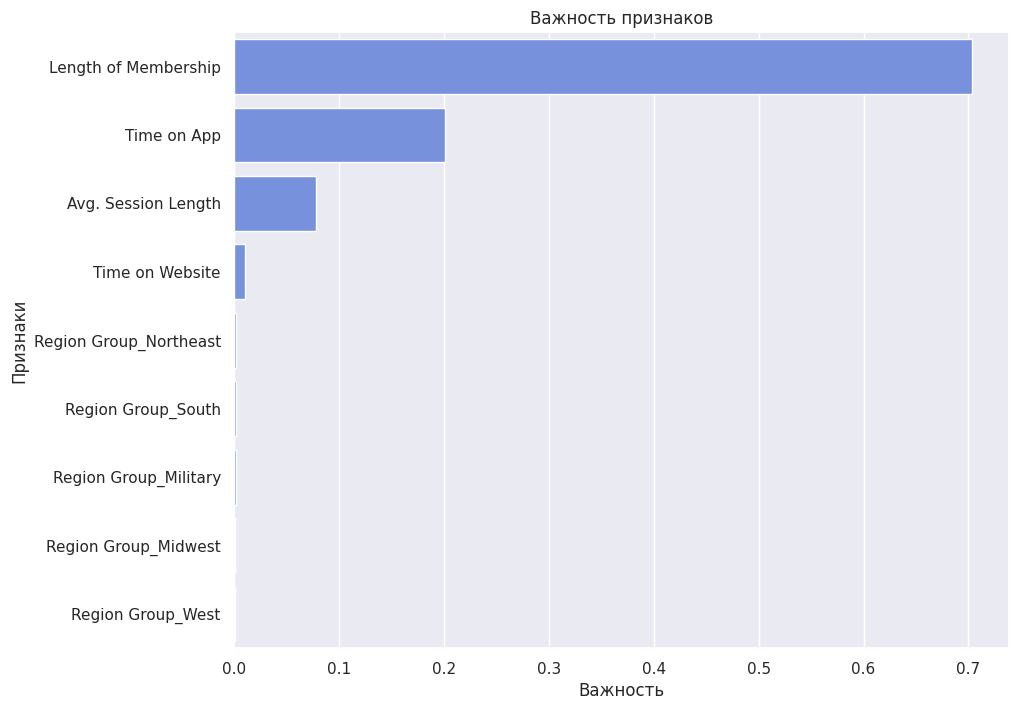

In [116]:
feature_names = X_train_sc.columns.tolist()
features_df = analyze_feature_importance(rf_model, feature_names)
print(features_df)
# визуализация важности признаков
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=features_df)
plt.title('Важность признаков')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.show()

Из результатов анализа важности признаков в модели случайного леса можно сделать следующие выводы:

- **Length of Membership** является наиболее значимым признаком, с весом приблизительно 70.3%, что указывает на его сильное влияние на годовые траты клиентов. Это может свидетельствовать о том, что продолжительность членства клиента сильно коррелирует с его лояльностью и, соответственно, с его тратами.

- **Time on App** — следующий по значимости признак с примерно 20.2% вклада. Это показывает, что время, проведённое клиентами в приложении, также существенно влияет на их годовые траты, подчеркивая важность качества и удобства мобильного приложения.

- **Avg. Session Length** имеет меньший вес (приблизительно 7.8%), что указывает на его меньшую, но все же значительную роль в предсказании годовых расходов.

- **Time on Website** имеет значительно меньшее влияние (около 2.5%) по сравнению с приложением. Это может сигнализировать о том, что веб-сайт менее эффективен в стимулировании трат клиентов или что усилия по улучшению пользовательского опыта должны быть сосредоточены на мобильном приложении.

- Категориальные признаки, связанные с группами регионов (**Region Group_South, Region Group_Northeast, Region Group_Military, Region Group_West, Region Group_Midwest**), имеют очень низкую важность (все менее 1%). Это указывает на то, что региональная принадлежность имеет минимальное влияние на годовые траты в данной модели.

По итогам обучения линейной регрессии мы убедились, что категориальные признаки снижают обучающую способность модели.

Исключим менее значимые признаки, чтобы уменьшить шум и потенциально улучшить производительность модели.

In [117]:
X_train_sc = X_train_sc[numerical_features].drop('Time on Website', axis=1)
X_test_sc = X_test_sc[numerical_features].drop('Time on Website', axis=1)
X_train_sc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 249 to 102
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Avg. Session Length   400 non-null    float64
 1   Time on App           400 non-null    float64
 2   Length of Membership  400 non-null    float64
dtypes: float64(3)
memory usage: 12.5 KB


RandomForestRegressor results:
Средняя абсолютная ошибка (MAE): 14.20
Среднеквадратичная ошибка (MSE): 384.64
Средний коэффициент детерминации (R²): 0.94


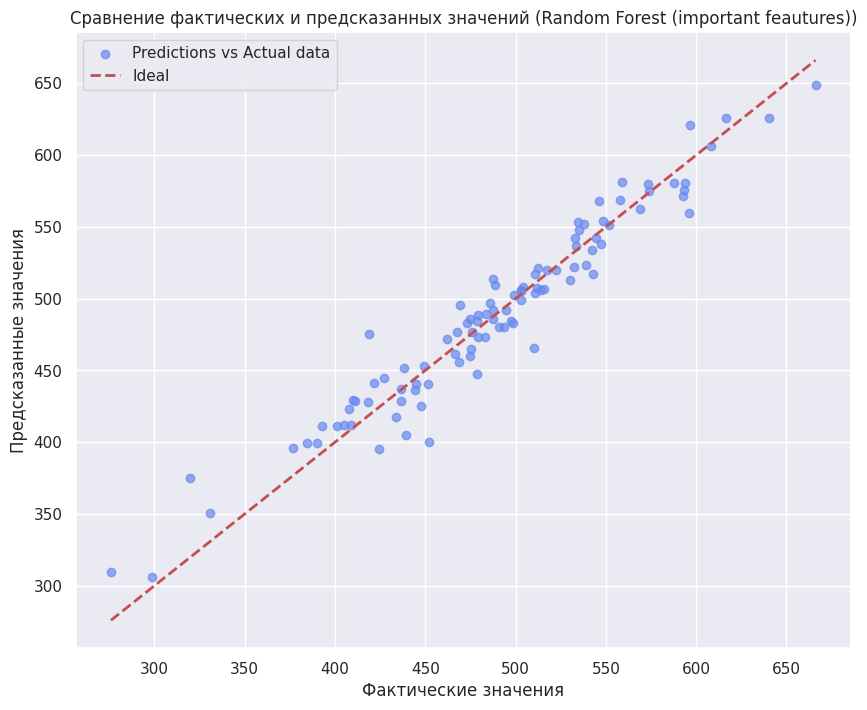

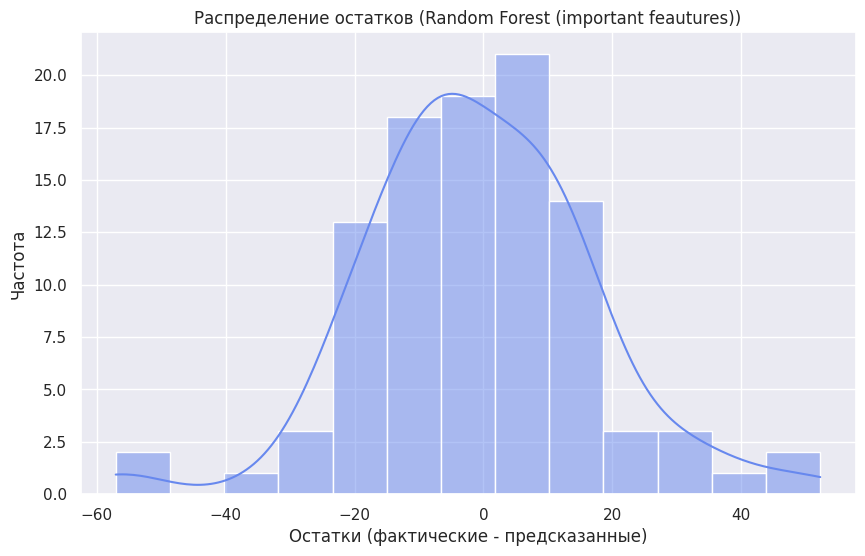

In [118]:
rf_model_if = RandomForestRegressor(random_state=42)
results = run_pipeline(rf_model_if, X_train_sc, y_train, X_test_sc, y_test, results, 'Random Forest (important feautures)')

In [119]:
results

,Model,MAE,MSE,R²
0,Baseline Linear Regression,7.831475,98.613220,0.984755
1,Scaled Linear Regression,7.892258,100.292574,0.984423
2,Random Forest Regressor,14.953219,427.833606,0.935006
3,Random Forest (important feautures),14.203864,384.643663,0.941494


**Результаты модели Random Forest с улучшенной выборкой признаков:**

- Средняя абсолютная ошибка (MAE): 14.20
- Среднеквадратичная ошибка (MSE): 384.64
- Коэффициент детерминации (R²): 0.94

**Анализ результатов:**

1. *Сравнение фактических и предсказанных значений:*
   График показывает, что предсказания модели близки к фактическим значениям, большинство точек следуют вдоль идеальной диагонали. Это указывает на хорошую точность модели в обобщенных условиях.

2. *Распределение остатков:*
   Распределение остатков приближено к нормальному, что является позитивным аспектом для регрессионных моделей. Однако имеется некоторая асимметрия, что может указывать на необходимость дополнительного исследования модели, подбора параметров.


- Удаление менее важного признака 'Time on Website' и фокусировка на наиболее значимых признаках позволила улучшить показатели модели. R² незначительно улучшился, что свидетельствует о повышении точности модели.
- Исключение категориальных признаков и менее важного числового признака из модели уменьшило переобучение и улучшило интерпретируемость результатов.
- Несмотря на улучшения, Random Forest не дотягивает по точности до линейных моделей в данном случае, что может быть связано с особенностями данных, более хорошо моделируемых линейными зависимостями.

## 4. Лин. рег. на важных признаках

Попробуем построить модель линейной регрессии на важных признаках.

LinearRegression results:
Средняя абсолютная ошибка (MAE): 7.82
Среднеквадратичная ошибка (MSE): 98.29
Средний коэффициент детерминации (R²): 0.98


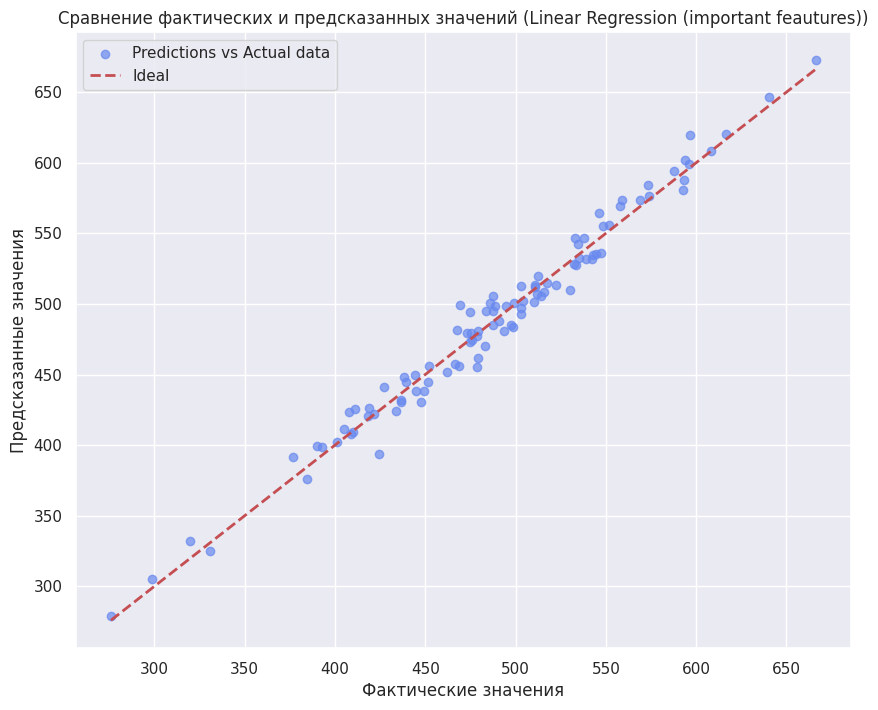

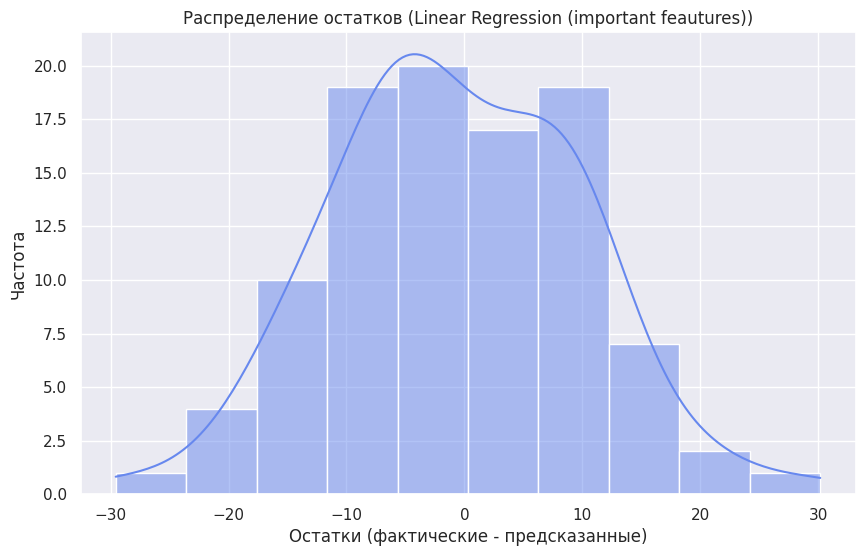

In [120]:
lin_reg_important = LinearRegression()
results = run_pipeline(lin_reg_important, X_train_sc, y_train, X_test_sc, y_test, results, 'Linear Regression (important feautures)')

In [121]:
results

,Model,MAE,MSE,R²
0,Baseline Linear Regression,7.831475,98.613220,0.984755
1,Scaled Linear Regression,7.892258,100.292574,0.984423
2,Random Forest Regressor,14.953219,427.833606,0.935006
3,Random Forest (important feautures),14.203864,384.643663,0.941494
4,Linear Regression (important feautures),7.816199,98.288983,0.984809


Удаление менее важных признаков помогло сфокусировать модель на наиболее значимых аспектах данных, что привело к улучшению всех трех ключевых метрик (MAE, MSE, и R²).

## 5. Gradient Boosting

GradientBoostingRegressor results:
Средняя абсолютная ошибка (MAE): 12.28
Среднеквадратичная ошибка (MSE): 282.84
Средний коэффициент детерминации (R²): 0.96


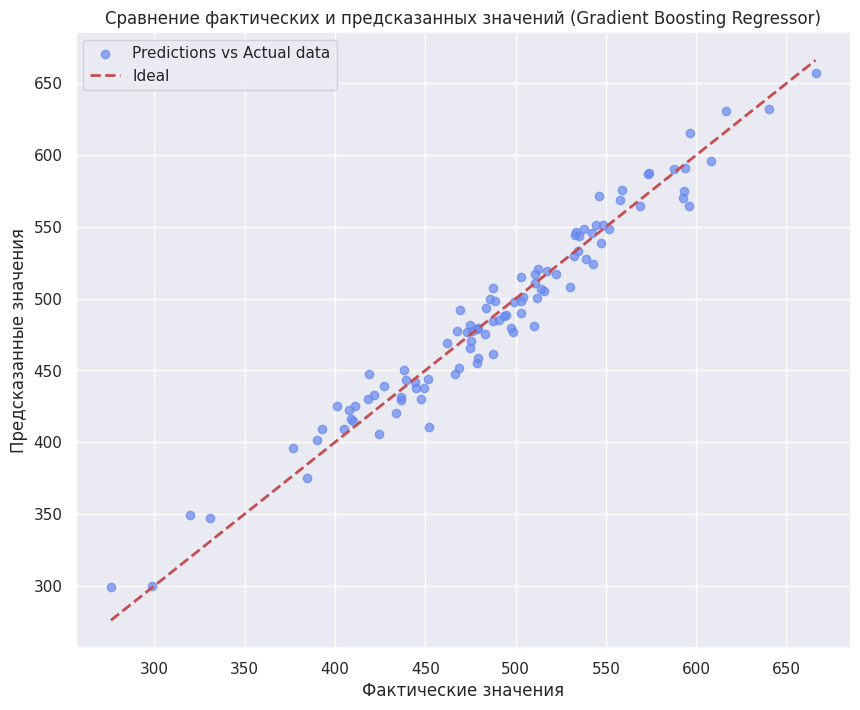

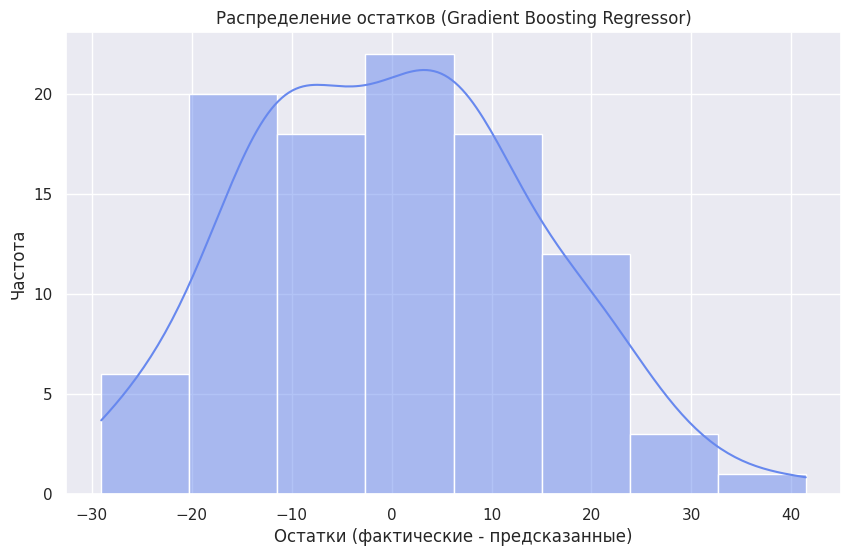

In [122]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(random_state=42)
results = run_pipeline(gb_model, X_train_sc, y_train, X_test_sc, y_test, results, 'Gradient Boosting Regressor')

In [123]:
results

,Model,MAE,MSE,R²
0,Baseline Linear Regression,7.831475,98.613220,0.984755
1,Scaled Linear Regression,7.892258,100.292574,0.984423
2,Random Forest Regressor,14.953219,427.833606,0.935006
3,Random Forest (important feautures),14.203864,384.643663,0.941494
4,Linear Regression (important feautures),7.816199,98.288983,0.984809
5,Gradient Boosting Regressor,12.284071,282.840529,0.956405


Модели линейной регрессии показывают лучшие результаты, но такие модели не являются устойчивыми. Попробуем объединить модели в ансамбли для большей устойчивости.

StackingRegressor results:
Средняя абсолютная ошибка (MAE): 7.77
Среднеквадратичная ошибка (MSE): 97.47
Средний коэффициент детерминации (R²): 0.98


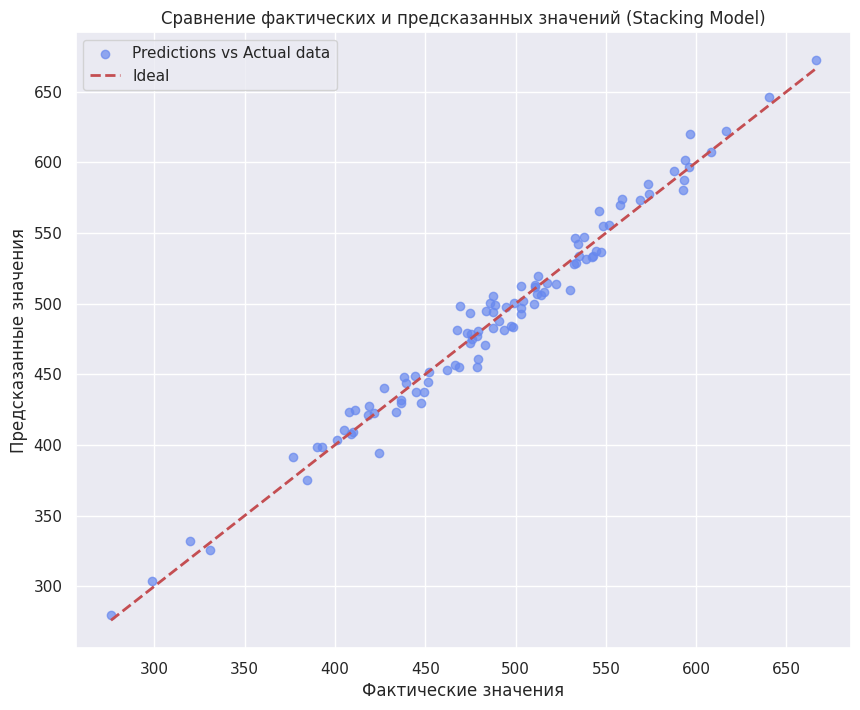

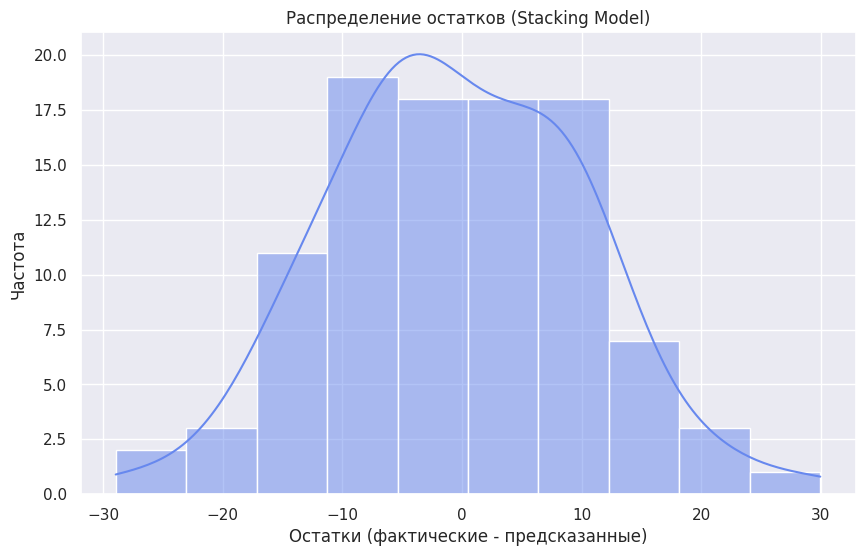

In [124]:
from sklearn.ensemble import StackingRegressor

# определение базовых моделей
estimators = [
    ('lr', LinearRegression()),
    ('gb', GradientBoostingRegressor(random_state=42))
]

# создание стекинг модели
stacked_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    cv=5
)

results = run_pipeline(stacked_model, X_train_sc, y_train, X_test_sc, y_test, results, 'Stacking Model')

In [125]:
results

,Model,MAE,MSE,R²
0,Baseline Linear Regression,7.831475,98.613220,0.984755
1,Scaled Linear Regression,7.892258,100.292574,0.984423
2,Random Forest Regressor,14.953219,427.833606,0.935006
3,Random Forest (important feautures),14.203864,384.643663,0.941494
4,Linear Regression (important feautures),7.816199,98.288983,0.984809
5,Gradient Boosting Regressor,12.284071,282.840529,0.956405
6,Stacking Model,7.771061,97.473091,0.984959


Результаты, полученные с помощью StackingRegressor, демонстрируют отличную производительность, сопоставимую с результатами лучших моделей линейной регрессии. Пока это самый высокий результат R² = 0.9849 (против 0.9848 у лин. регрессии).

# Лучшие модели

## Подбор гиперпараметров GridSearchCV

Мы можем применить подбор гиперпараметров grid search для моделей, которые имеют наилучшую базовую производительность и для которых гиперпараметры имеют большое значение. Например, для моделей, показавших хорошие результаты на базовом уровне, таких как Linear Regression на важных признаках и Gradient Boosting Regressor и Stacking Model.

In [126]:
results

,Model,MAE,MSE,R²
0,Baseline Linear Regression,7.831475,98.613220,0.984755
1,Scaled Linear Regression,7.892258,100.292574,0.984423
2,Random Forest Regressor,14.953219,427.833606,0.935006
3,Random Forest (important feautures),14.203864,384.643663,0.941494
4,Linear Regression (important feautures),7.816199,98.288983,0.984809
5,Gradient Boosting Regressor,12.284071,282.840529,0.956405
6,Stacking Model,7.771061,97.473091,0.984959


In [127]:
from sklearn.model_selection import GridSearchCV

# функция для подбора гиперпараметров
def grid_search_model(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    # best_model = grid_search.best_estimator_
    return best_params, best_score

In [128]:
# переопределим модели линейной регрессии и градиентного бустинга
lin_reg_important = LinearRegression()
gb_model = GradientBoostingRegressor(random_state=42)

# переопределим stacking model
estimators = [
    ('lr', LinearRegression()),
    ('gb', GradientBoostingRegressor(random_state=42)),
]
stacked_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    cv=5
)

In [129]:
# зададим параметры для перебора

# параметры для Linear Regression
param_grid_lr = {
    'fit_intercept': [True, False],  # подбор свободного члена, default=True
    'copy_X': [True, False],        # копирование X при обучении, default=True
    'n_jobs': [None, -1, 1, 2],     # количество параллельных задач, default=None
    'positive': [True, False]       # модель предсказывает только положительные значения, default=False
}

# параметры для Gradient Boosting Regressor
param_grid_gb = {
    'loss': ['ls', 'lad', 'huber', 'quantile'],  # функция потерь
    'learning_rate': [0.1, 0.01, 0.001],         # скорость обучения
    'n_estimators': [100, 500, 1000],            # количество деревьев
    'max_depth': [3, 5, 7, 10],                  # максимальная глубина деревьев
    'max_features': ['auto', 'sqrt', 'log2'],    # количество функций для поиска лучшего разделения
}

# парметры для стекинга
param_grid_stacked = {
    'lr__fit_intercept': [True, False],
    'gb__n_estimators': [100, 200],
    'gb__learning_rate': [0.05, 0.1],
    'final_estimator__fit_intercept': [True, False]
}

In [130]:
results

,Model,MAE,MSE,R²
0,Baseline Linear Regression,7.831475,98.613220,0.984755
1,Scaled Linear Regression,7.892258,100.292574,0.984423
2,Random Forest Regressor,14.953219,427.833606,0.935006
3,Random Forest (important feautures),14.203864,384.643663,0.941494
4,Linear Regression (important feautures),7.816199,98.288983,0.984809
5,Gradient Boosting Regressor,12.284071,282.840529,0.956405
6,Stacking Model,7.771061,97.473091,0.984959


In [131]:
# подбор гиперпараметров для Lin Reg на важных признаках
best_params_lin, best_score_lin = grid_search_model(lin_reg_important, param_grid_lr, X_train_sc, y_train)
print("Лучшие параметры для Linear Regression:", best_params_lin)
print("Лучший score для Linear Regression:", best_score_lin)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Лучшие параметры для Linear Regression: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': True}
Лучший score для Linear Regression: 0.984901693642396


Для линейной регресси лучшие параметры являются параметры по-умолчанию, поэтому мы получили такой же результат, как при обучении лин. рег. на важных признаках.

In [64]:
# подбор гиперпараметров для Gradient Boosting
best_params_gb, best_score_gb = grid_search_model(gb_model, param_grid_gb, X_train_sc, y_train)
print("Лучшие параметры для Gradient Boosting:", best_params_gb)
print("Лучший score для Gradient Boosting:", best_score_gb)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


KeyboardInterrupt: 

In [133]:
best_params_stacked, best_score_stacked = grid_search_model(stacked_model, param_grid_stacked, X_train_sc, y_train)
print("Лучшие параметры для Stacking Model:", best_params_stacked)
print("Лучший score для Stacking Model:", best_score_stacked)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Лучшие параметры для Stacking Model: {'final_estimator__fit_intercept': True, 'gb__learning_rate': 0.1, 'gb__n_estimators': 100, 'lr__fit_intercept': True}
Лучший score для Stacking Model: 0.9850033771552335


Стекинг показывает лучший результат и является более устойчивой и надежной моделью. Обучим модель стекинга на лучших параметрах.

StackingRegressor results:
Средняя абсолютная ошибка (MAE): 7.77
Среднеквадратичная ошибка (MSE): 97.47
Средний коэффициент детерминации (R²): 0.98


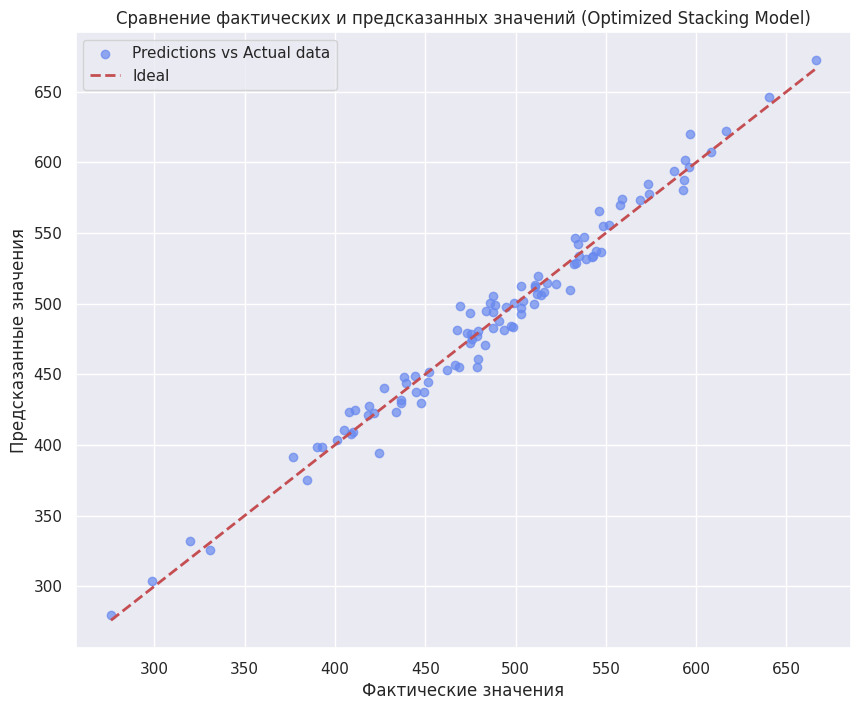

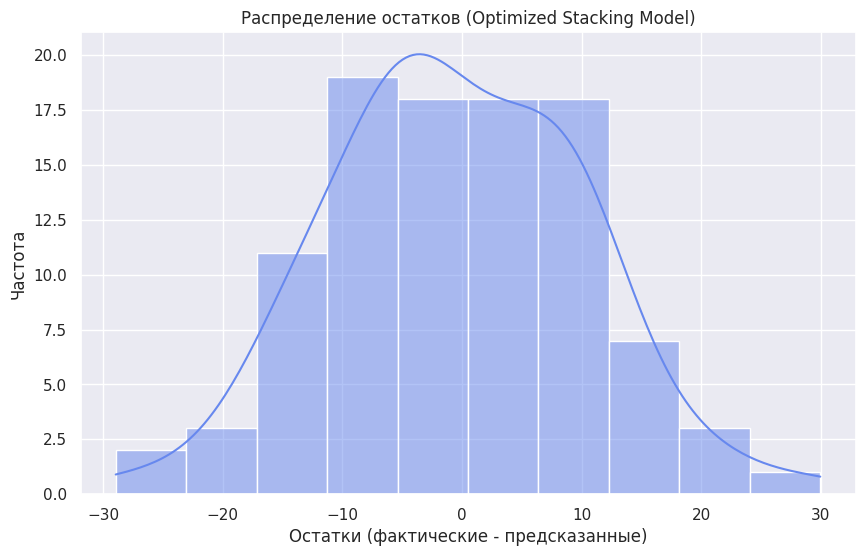

In [134]:
# переопределим stacking model
estimators = [
    ('lr', LinearRegression(fit_intercept=True)),
    ('gb', GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, random_state=42)),
]
optimized_stacked_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(fit_intercept=True),
    cv=5
)

results = run_pipeline(optimized_stacked_model, X_train_sc, y_train, X_test_sc, y_test, results, 'Optimized Stacking Model')

In [137]:
results

,Model,MAE,MSE,R²
0,Baseline Linear Regression,7.831475,98.613220,0.984755
1,Scaled Linear Regression,7.892258,100.292574,0.984423
2,Random Forest Regressor,14.953219,427.833606,0.935006
3,Random Forest (important feautures),14.203864,384.643663,0.941494
4,Linear Regression (important feautures),7.816199,98.288983,0.984809
5,Gradient Boosting Regressor,12.284071,282.840529,0.956405
6,Stacking Model,7.771061,97.473091,0.984959
7,Optimized Stacking Model,7.771061,97.473091,0.984959


In [138]:
import joblib
joblib.dump(optimized_stacked_model, 'optimized_stacking_model.pkl')

['optimized_stacking_model.pkl']

# Пайплайн для работы с новыми данными


In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [ ]:
def create_preprocessor():
    """
    Создает и возвращает пайплайн для предобработки числовых признаков.

    Returns:
    ColumnTransformer: Пайплайн для предобработки данных.
    """
    numerical_features = ['Avg. Session Length', 'Time on App', 'Time on Website', 'Length of Membership']
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features)
        ])
    return preprocessor

def load_model(model_path='optimized_stacking_model.pkl'):
    """
    Загружает и возвращает сохраненную модель.

    Parameters:
    model_path (str): Путь к сохраненной модели.

    Returns:
    Pipeline: Загруженная модель.
    """
    return joblib.load(model_path)

In [ ]:
def predict_new_data(model_pipeline, new_data_path):
    """
    Делает предсказания на новых данных с использованием загруженной модели.

    Parameters:
    model_pipeline (Pipeline): Загруженная модель с предобработкой.
    new_data_path (str): Путь к новым данным для предсказания.

    Returns:
    pd.Series: Предсказанные значения.
    """
    new_data = pd.read_csv(new_data_path)
    predictions = model_pipeline.predict(new_data)
    return predictions

In [ ]:
def evaluate_model(model_pipeline, data_path):
    """
    Оценивает модель на тестовых данных и выводит метрики.

    Parameters:
    model_pipeline (Pipeline): Загруженная модель с предобработкой.
    data_path (str): Путь к данным для оценки.

    Returns:
    None
    """
    data = pd.read_csv(data_path)
    X = data[['Avg. Session Length', 'Time on App', 'Time on Website', 'Length of Membership']]
    y = data['Yearly Amount Spent']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    y_pred = model_pipeline.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("Evaluation on test data:")
    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("R-squared (R2):", r2)

In [ ]:
def main(data_path, new_data_path, model_path='optimized_stacking_model.pkl'):
    """
    Основная функция для запуска полного пайплайна.

    Parameters:
    data_path (str): Путь к данным для обучения модели.
    new_data_path (str): Путь к новым данным для предсказания.
    model_path (str): Путь к сохраненной модели.

    Returns:
    None
    """
    preprocessor = create_preprocessor()
    model_pipeline = load_model(model_path)

    # Объединение предобработки и модели в один пайплайн
    full_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model_pipeline.named_steps['model'])
    ])

    # Оценка модели
    evaluate_model(full_pipeline, data_path)

    # Предсказания на новых данных
    predictions = predict_new_data(full_pipeline, new_data_path)

    print("Predictions for new data:")
    print(predictions)

if __name__ == "__main__":
    # Укажите путь к вашим данным
    data_path = 'path_to_your_data.csv'
    new_data_path = 'path_to_new_data.csv'

    main(data_path, new_data_path)

# Выводы

1. Анализ показал, что длительность участия (Length of Membership) имеет существенное влияние на годовые траты клиентов. Этот фактор может быть ключевым для повышения доходов компании.

2. Коэффициент корреляции признака Time on App с годовыми тратами равен 0.499, что указывает на значимую, но не сильную связь.

3. Несмотря на относительно слабые связи 'Yearly Amount Spent' с другими признаками, время, проведенное на сайте, по-прежнему вносит существенный вклад в объяснение изменчивости годовых трат. Это подтверждается высоким значением коэффициента детерминации (R2 = 0.9778) в модели, включающей все четыре признака.

Рекомендации:

  - **Фокус на удержании клиентов:** Важно уделять внимание удержанию клиентов и стимулированию их участия в услугах компании на протяжении длительного времени, так как продолжительность членства оказывает наибольшее влияние на годовые затраты. Чем лояльнее клиент - тем больше он тратит.

  - **Работа над приложением**: Увеличение времени, проведенного пользователем в приложении, хорошо сказывается на тратах. Необходимо постоянно улучшать пользовательский опыт, предлагать услуги, акции и добавлять триггеры к покупке.

  - **Персонализация и улучшение обслуживания:**
  Работа по улучшению и персонализации услуг, которые компания предоставляет клиентам, может способствовать увеличению их длительности участия, активности в приложении и, следовательно, годовых трат.